In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import itertools
import random as python_random
from keras.initializers import GlorotUniform
from keras.initializers import Orthogonal
from keras.initializers import HeNormal
from keras.initializers import HeUniform
from keras.initializers import RandomNormal
from keras.regularizers import L1L2

np.random.seed(42)
tf.random.set_seed(42)
python_random.seed(42)

In [2]:
def load_data(filepath):
    return pd.read_csv(filepath, parse_dates=['Date'])

In [3]:
def create_sequences(data, target, n_steps):
    X, y = [], []
    # print("data", data[:15])
    # print("target", target[:15])
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps)])
        y.append(target[i + n_steps])
    return np.array(X), np.array(y)

In [4]:
def modify_data(data):
    result = None
    # print(data)

    # copy LMCADY_acu_5d_log into a new column ACU_5D and shift it by 5 days
    data['ACU_5D'] = data['LMCADY_acu_5d_log']
    data['ACU_5D'] = data['ACU_5D'].shift(5)

    data['ACU_4D'] = data['LMCADY'].rolling(window=4).sum()
    data['ACU_3D'] = data['LMCADY'].rolling(window=3).sum()
    data['ACU_2D'] = data['LMCADY'].rolling(window=2).sum()

    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)

    result = data
    # print(result.head(10))
    return result

In [5]:
def prepare_data(df, target_column, n_steps, feature_list = []):

    df = modify_data(df)
    df.to_csv('../output/modified_data.csv', index=False)

    features = df.drop(columns=[target_column, 'LMCADY_std_5d_log'])
    features = features.drop(columns = ['Date'])
    features = features[feature_list]
    print("Features utilizados:",features.columns)

    target = df[target_column]

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    X, y = create_sequences(features_scaled, target, n_steps)
    # for i in range(15):
    #     print(X[i][0][0], y[i])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle = False)

    return X_train, X_test, y_train, y_test

In [6]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [7]:
def build_model(input_shape, md_prm: dict):
    model = Sequential()
    initializer = md_prm['initializer']  # Usando Orthogonal como inicializador

    # Añadiendo más capas LSTM y dropout
    model.add(LSTM(md_prm['lstm_units1'], return_sequences=True, input_shape=input_shape, kernel_initializer=initializer, activation='relu', dropout=0.15))
    model.add(LSTM(md_prm['lstm_units2'], return_sequences=True, kernel_initializer=initializer, activation='relu', dropout=0.15))
    model.add(LSTM(md_prm['lstm_units2'], kernel_initializer=initializer, activation='relu'))  # Capa adicional LSTM
    model.add(Dense(50, activation='relu', kernel_initializer=initializer))  # Capa Dense adicional
    model.add(Dense(1, kernel_initializer=initializer))

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=[rmse])
    return model


In [8]:
def train_model(model, X_train, y_train, epochs, batch_size, verbose):

    early_stopping = EarlyStopping(
        monitor             ='val_loss',
        patience            =75,
        verbose             =1,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        epochs              =epochs,
        batch_size          =batch_size,
        verbose             =verbose,
        callbacks           =[early_stopping],
        validation_split    =0.05
    )

    return history

In [9]:
def evaluate_model(model, X_test, y_test):
    return model.evaluate(X_test, y_test)

In [10]:
def plot_predictions(y_true, y_pred, n=-1, title="Prediction vs Actual Data", markersize=3, rmse=None):
    if n != -1:
        n = min(n, len(y_true), len(y_pred))

        y_true = y_true[-n:]
        y_pred = y_pred[-n:]

    plt.figure(figsize=(18, 2.5))
    plt.plot(y_true, label='Actual Values', marker='o', linestyle='-', markersize=markersize)

    # Plot the RMSE lines if rmse is provided
    if rmse is not None:
        plt.axhline(y= rmse, color='green', linestyle='--', linewidth=0.7)
        plt.axhline(y=-rmse, color='green', linestyle='--', linewidth=0.7)

        tot_pred = 0
        prof = 0
        loss = 0

        # plot green markers beyond the rmse range
        for i in range(len(y_pred)):
            if (y_pred[i] > rmse or y_pred[i] < - rmse):
                # print("{} {}".format(y_pred[i],y_true[i]))
                if (y_true[i] > 0 and y_pred[i] > 0) or (y_true[i] < 0 and y_pred[i] < 0):
                    plt.plot(i, y_pred[i], 'gx', markersize=markersize+1)
                    prof += 1
                else:
                    plt.plot(i, y_pred[i], 'rx', markersize=markersize+1)
                    loss += 1
                tot_pred += 1
            else:
                plt.plot(i, y_pred[i], marker='x', color='orange', markersize=markersize-1)

    else:
        plt.plot(y_true, label='Actual Values'   , marker='o', linestyle='-' , markersize=markersize)
        plt.plot(y_pred, label='Predicted Values', marker='x', linestyle='--', markersize=markersize)

    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.7)

    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    return tot_pred, prof, loss

In [11]:
def trend_accuracy(y_true, y_pred):
    trend_up_true = 0
    trend_down_true = 0
    trend_up_pred = 0
    trend_down_pred = 0

    for j in range(len(y_true)-1):
        if y_true[j] > 0.0:
            trend_up_pred += 1
            if y_pred[j] > 0.0:
                trend_up_true += 1
        if y_true[j] < 0.0:
            trend_down_pred += 1
            if y_pred[j] < 0.0:
                trend_down_true += 1

    trend_true = trend_up_true + trend_down_true
    trend_pred = trend_up_pred + trend_down_pred

    trend_up_accuracy = trend_up_true/trend_up_pred
    trend_down_accuracy = trend_down_true/trend_down_pred
    trend_accuracy = trend_true/trend_pred

    return trend_accuracy, trend_up_accuracy, trend_down_accuracy

In [12]:
n_steps_options     = [40,60,120]
batch_size_options  = [256,128]
epochs_options      = [300]

lstm_units_options1 = [75,25]
lstm_units_options2 = [25]
initializer         = [ 
                        GlorotUniform(seed=42), 
                        # HeNormal(seed=42), 
                        # HeUniform(seed=42), 
                        Orthogonal(seed=42)
                        ]
activation_options  = ['relu']
dropout_options     = [.15]
num_layers_options  = [2]

# # caso seleccionado
# n_steps_options     = [120]
# batch_size_options  = [256]
# epochs_options      = [300]

# lstm_units_options  = [25]
# activation_options  = ['relu']
# dropout_options     = [.15]
# num_layers_options  = [2]

# variable_options = ['LMCADS03','LMCADY','SPX','MXWD','XAU','XAG','ACU_5D','ACU_4D','ACU_3D','ACU_2D']
# modified_lists = [variable_options[:i] + variable_options[i+1:] for i in range(len(variable_options))]
# print(modified_lists)
modified_lists = [['LMCADS03','LMCADY','SPX','MXWD','XAG','XAU','ACU_5D','ACU_4D','ACU_3D','ACU_2D']]

# combinations
model_params_combinations = list(itertools.product(
    n_steps_options     ,
    lstm_units_options1,
    lstm_units_options2,
    initializer        ,
    activation_options,
    dropout_options,
    num_layers_options,
    batch_size_options,
    epochs_options,
    modified_lists
))
target_column = 'LMCADY_acu_5d_log'

In [13]:
n_iterations = len(model_params_combinations)
print("Total iterations: {}".format(n_iterations))

Total iterations: 24


In [14]:
def run_model_iterations():
    top_results = []
    i = 1
    for params in model_params_combinations:
        n_steps, lstm_units1, lstm_units2, initializer, activation, dropout, num_layers, batch_size, epochs, var_options = params
        try:

            # data load
            df = load_data("../input/copper_log_returns_5d_final.csv")
            print("\nIteration {}/{}".format(i, n_iterations))
            # print("Params: n_steps: {}, lstm_units1: {}, lstm_units2: {}, activation: {}, dropout: {}, num_layers: {}".format(
            #     n_steps, lstm_units1, lstm_units2, activation, dropout, num_layers)
            # )

            print("Train : batch    > {}".format(batch_size))
            print("        epochs   > {}".format(epochs))
            print("        n_steps  > {}".format(n_steps))
            
            # data preparation
            # print("Variables used: {}".format(var_options))
            X_train, X_test, y_train, y_test = prepare_data(df, target_column, n_steps, var_options)

            # build model
            model_params = {
                'lstm_units1'   : lstm_units1,
                'lstm_units2'   : lstm_units2,
                'activation'    : activation,
                'dropout'       : dropout,
                'num_layers'    : num_layers,
                'initializer'   : initializer
            }
            print("Model params: \n{}".format(model_params))

            input_shape = (X_train.shape[1], X_train.shape[2])
            print("Input shape: {}".format(input_shape))
            model = build_model(input_shape, model_params)
            print(model.summary())

            # model train
            if True:
                history = train_model(model, X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

                # model evaluation
                y_pred      = model.predict(X_test)
                rmse_score  = math.sqrt(mean_squared_error(y_test, y_pred))
                std_dev     = np.std(y_test)

                print("Pred std dev: {:.6f}, test std dev: {:.6f}".format(np.std(y_pred), std_dev))

                if rmse_score < std_dev:
                    diff = rmse_score - std_dev + abs(np.std(y_pred) - std_dev)/4.0
                else:
                    diff = (rmse_score - std_dev) + abs(np.std(y_pred) - std_dev)/2.0

                # diff = (rmse_score - std_dev) + abs(np.std(y_pred) - std_dev)/2.0
                tren_acc, trend_up, trend_down = trend_accuracy(y_test, y_pred)
                result = {
                    'md_prm'    : model_params,
                    'n_steps'   : n_steps,
                    'batch_size': batch_size,
                    'epochs'    : epochs,
                    'rmse'      : rmse_score,
                    'std_dev'   : std_dev,
                    'diff'      : diff,
                    'predictions': y_pred,
                    'true_values': y_test,
                    'feature_list': var_options,
                    'tr_ac': tren_acc,
                    'tr_up': trend_up,
                    'tr_down': trend_down
                }

                print("RMSE: {:.6f}, STD_DEV: {:.6f}, STD_PRD: {:.6f}, OBJDIFF: {:.6f}, RDIFF: {:.6f}".format(rmse_score, std_dev, np.std(y_pred), diff, (rmse_score - std_dev)))
                print("Trend: {:.2f}, Up: {:.2f}, Down: {:.2f}".format(tren_acc*100, trend_up*100, trend_down*100))

                top_results.append(result)
                top_results = sorted(top_results, key=lambda x: x['diff'])
                tot_pred, prof, loss = plot_predictions(result['true_values'], result['predictions'], -1, title="It. {}".format(i),rmse = rmse_score)
                print("Total TH Pred.: {}".format(tot_pred))
                if tot_pred != 0:
                    print("TH Pred. acc. : {:.2f}".format(prof*100.0/tot_pred))

            print("Completed Iteration {}/{}".format(i, n_iterations))
        except Exception as ex:
            print(f"An error occurred: {ex}. Skipping this combination.")
        i += 1
    return top_results

In [15]:
top_results = run_model_iterations()


Iteration 1/24
Train : batch    > 256
        epochs   > 300
        n_steps  > 40
Features utilizados: Index(['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D',
       'ACU_3D', 'ACU_2D'],
      dtype='object')
Model params: 
{'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.initializers.initializers_v2.GlorotUniform object at 0x000001D79CD2C2E0>}
Input shape: (40, 10)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 75)            25800     
                                                                 
 lstm_1 (LSTM)               (None, 40, 25)            10100     
                                                                 
 lstm_2 (LSTM)               (None, 25)                5100      
                                                         

KeyboardInterrupt: 

In [ ]:
top_results_sort = sorted(top_results, key=lambda x: x['diff'])[:15]

Top 1 - 0.5
RMSE: 0.021396, STD_DEV: 0.021968, STD_PRD: 0.007593, OBJDIFF: 0.003022, RDIFF: -0.000572
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023853, inv. diff> 0.009073
Trend accuracy       : 59.273
Trend up accuracy    : 76.712
Trend down accuracy  : 39.535


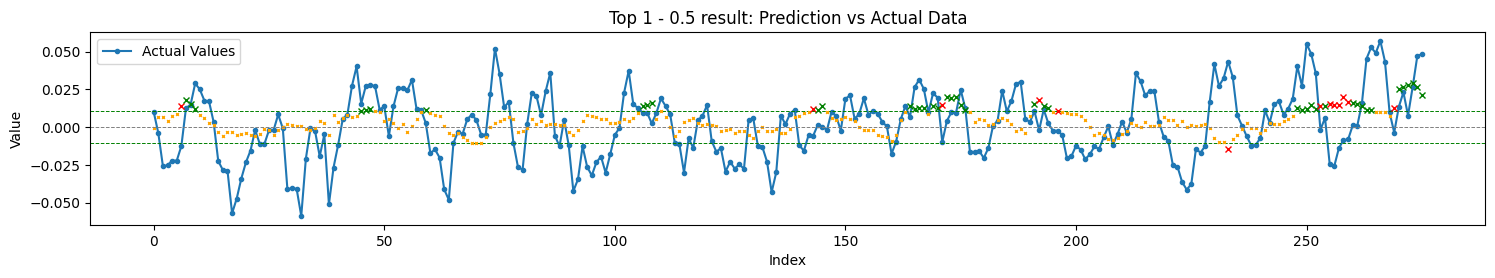

Total TH Pred.: 56
TH Pred. acc. : 76.79


Top 2 - 0.5
RMSE: 0.021314, STD_DEV: 0.022002, STD_PRD: 0.006986, OBJDIFF: 0.003066, RDIFF: -0.000688
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023377, inv. diff> 0.008883
Trend accuracy       : 53.650
Trend up accuracy    : 69.655
Trend down accuracy  : 35.659


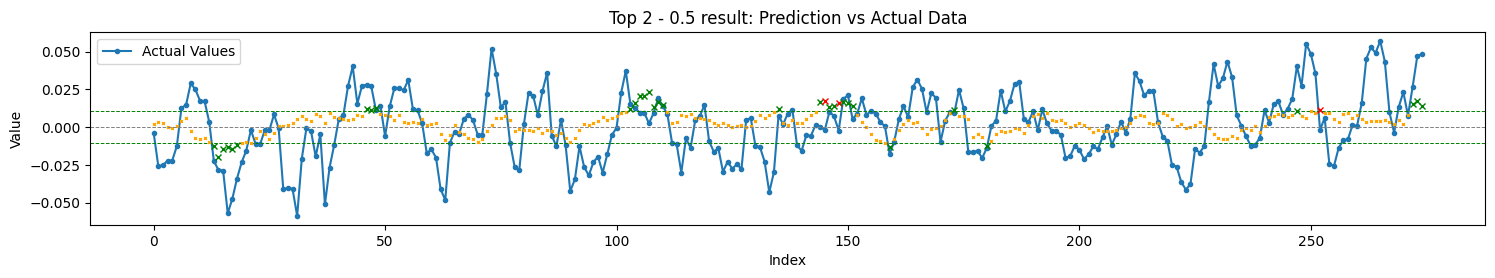

Total TH Pred.: 34
TH Pred. acc. : 91.18


Top 3 - 0.5
RMSE: 0.021549, STD_DEV: 0.022002, STD_PRD: 0.007305, OBJDIFF: 0.003222, RDIFF: -0.000452
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023508, inv. diff> 0.008855
Trend accuracy       : 59.124
Trend up accuracy    : 69.655
Trend down accuracy  : 47.287


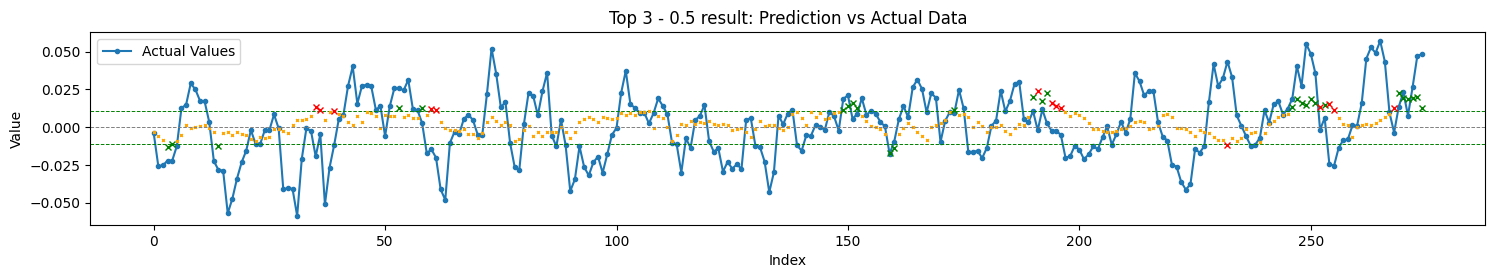

Total TH Pred.: 42
TH Pred. acc. : 66.67


Top 4 - 0.5
RMSE: 0.021346, STD_DEV: 0.022002, STD_PRD: 0.005851, OBJDIFF: 0.003382, RDIFF: -0.000656
batch_size: 64, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023008, inv. diff> 0.009081
Trend accuracy       : 57.934
Trend up accuracy    : 73.103
Trend down accuracy  : 40.476


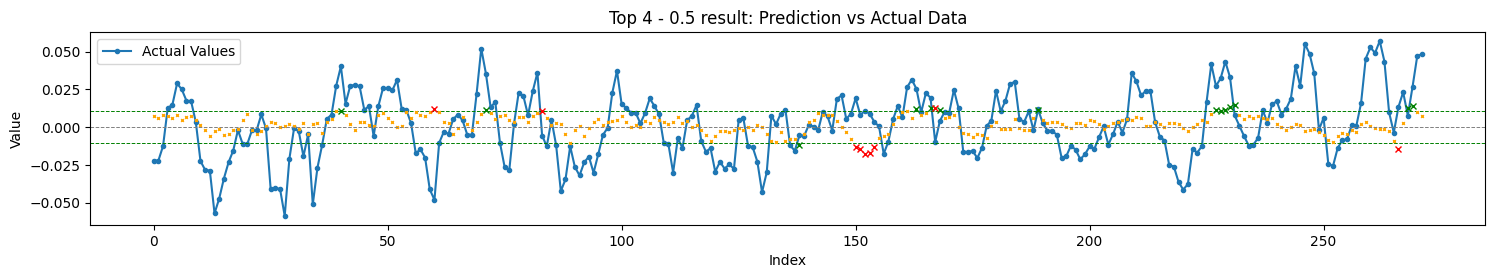

Total TH Pred.: 23
TH Pred. acc. : 60.87


Top 5 - 0.5
RMSE: 0.021730, STD_DEV: 0.021968, STD_PRD: 0.007309, OBJDIFF: 0.003427, RDIFF: -0.000238
batch_size: 64, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023367, inv. diff> 0.008729
Trend accuracy       : 58.909
Trend up accuracy    : 70.548
Trend down accuracy  : 45.736


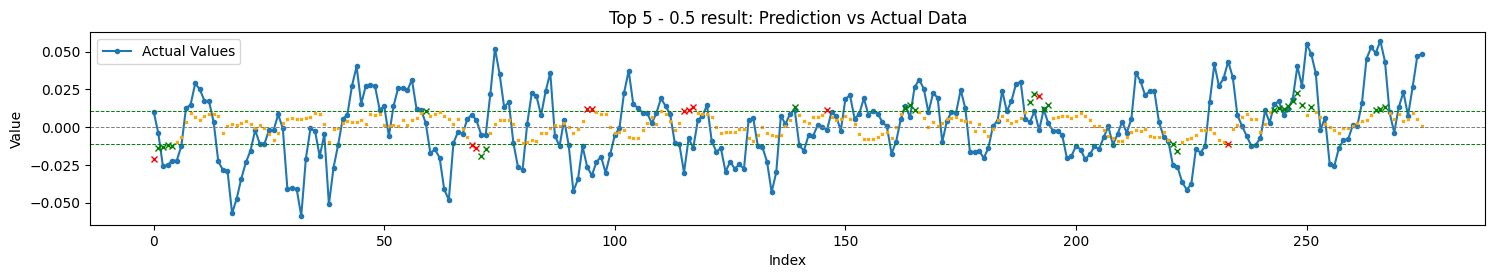

Total TH Pred.: 39
TH Pred. acc. : 71.79


Top 6 - 0.5
RMSE: 0.021968, STD_DEV: 0.021968, STD_PRD: 0.006441, OBJDIFF: 0.003881, RDIFF: -0.000001
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023266, inv. diff> 0.009062
Trend accuracy       : 56.364
Trend up accuracy    : 71.918
Trend down accuracy  : 38.760


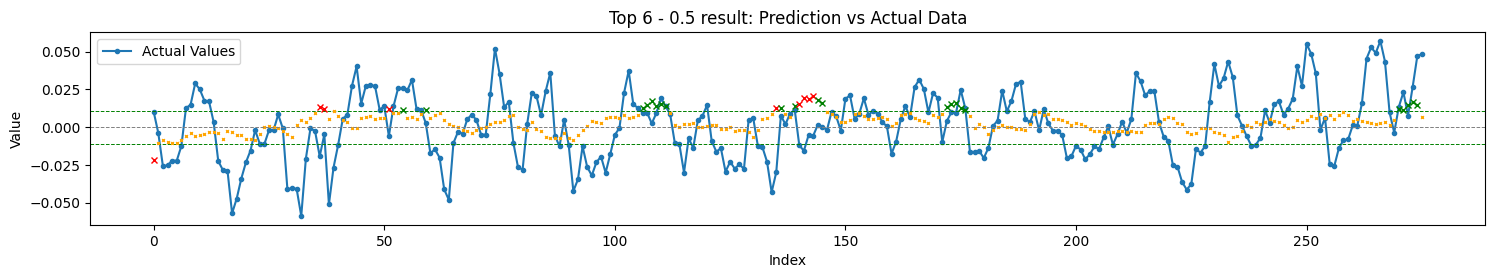

Total TH Pred.: 31
TH Pred. acc. : 70.97


Top 7 - 0.5
RMSE: 0.021253, STD_DEV: 0.021968, STD_PRD: 0.003182, OBJDIFF: 0.003981, RDIFF: -0.000715
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022365, inv. diff> 0.009790
Trend accuracy       : 53.455
Trend up accuracy    : 70.548
Trend down accuracy  : 34.109


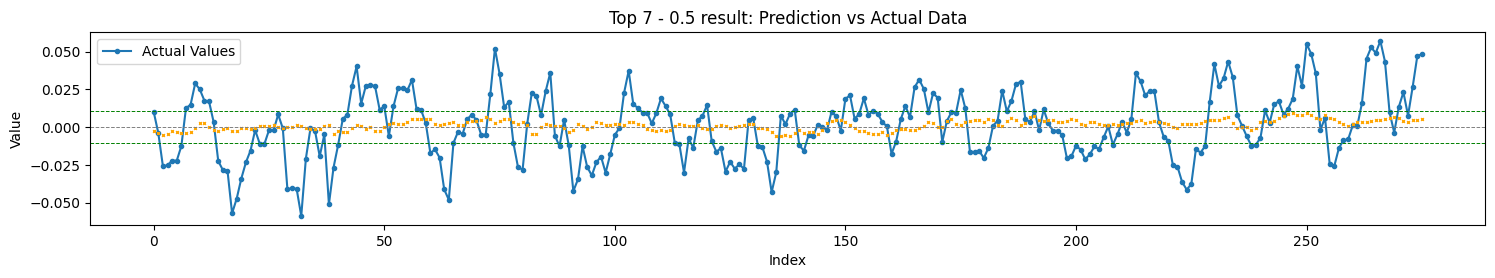

Total TH Pred.: 0


Top 8 - 0.5
RMSE: 0.021928, STD_DEV: 0.022002, STD_PRD: 0.005410, OBJDIFF: 0.004074, RDIFF: -0.000074
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 75, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022877, inv. diff> 0.009171
Trend accuracy       : 52.030
Trend up accuracy    : 64.828
Trend down accuracy  : 37.302


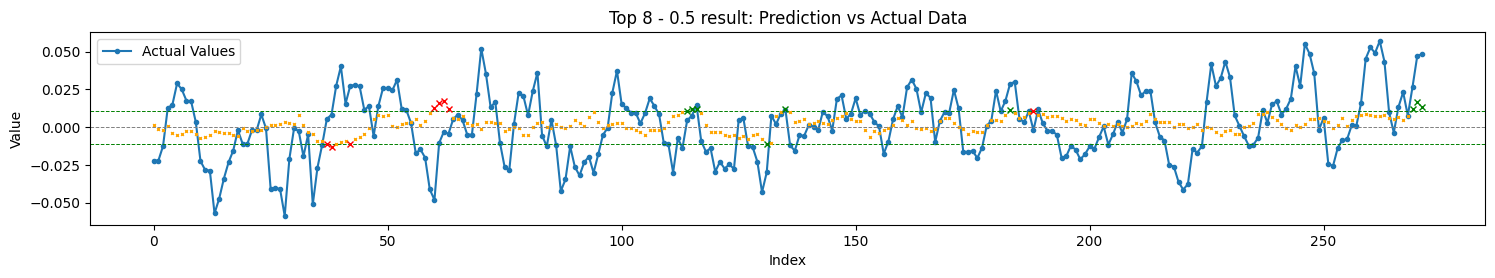

Total TH Pred.: 17
TH Pred. acc. : 52.94


Top 9 - 0.5
RMSE: 0.021642, STD_DEV: 0.022002, STD_PRD: 0.003914, OBJDIFF: 0.004162, RDIFF: -0.000359
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022384, inv. diff> 0.009426
Trend accuracy       : 57.934
Trend up accuracy    : 57.931
Trend down accuracy  : 57.937


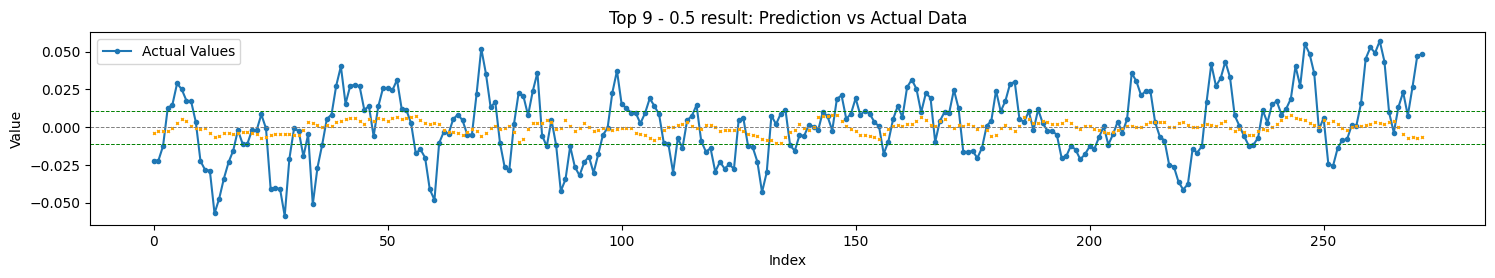

Total TH Pred.: 0


Top 10 - 0.5
RMSE: 0.021897, STD_DEV: 0.021968, STD_PRD: 0.003949, OBJDIFF: 0.004433, RDIFF: -0.000072
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022321, inv. diff> 0.009362
Trend accuracy       : 52.364
Trend up accuracy    : 39.041
Trend down accuracy  : 67.442


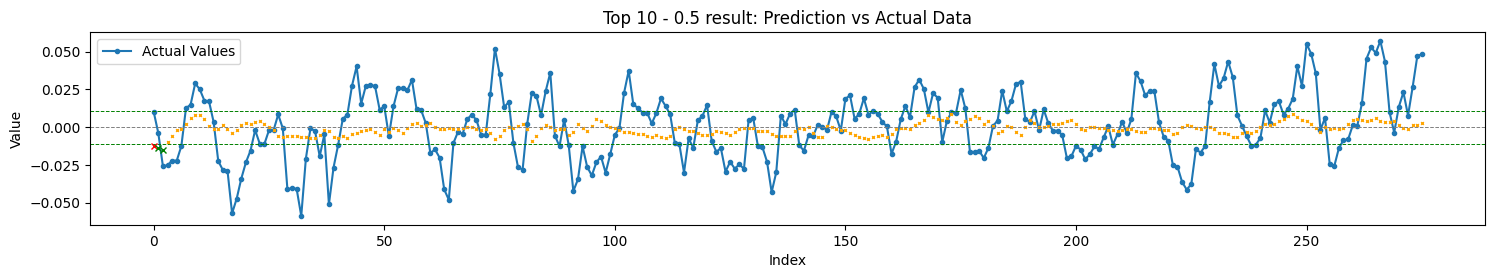

Total TH Pred.: 3
TH Pred. acc. : 66.67


Top 11 - 0.5
RMSE: 0.021910, STD_DEV: 0.021968, STD_PRD: 0.003931, OBJDIFF: 0.004451, RDIFF: -0.000059
batch_size: 64, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022419, inv. diff> 0.009469
Trend accuracy       : 49.455
Trend up accuracy    : 63.014
Trend down accuracy  : 34.109


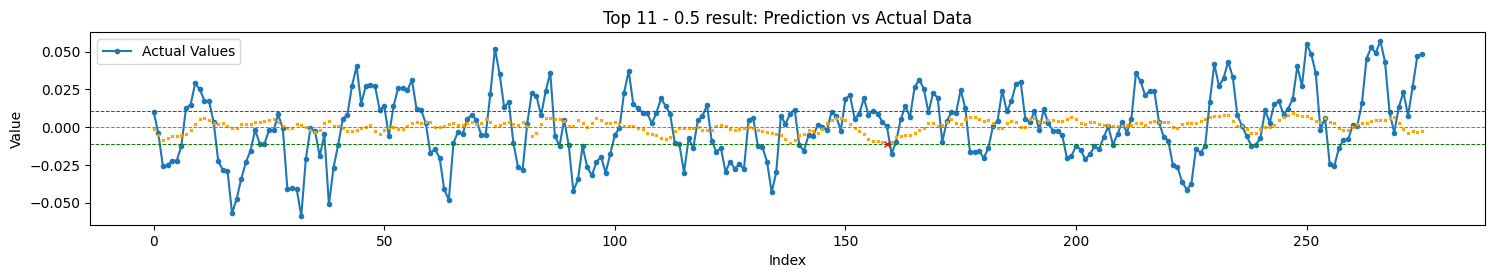

Total TH Pred.: 1
TH Pred. acc. : 0.00


Top 12 - 0.5
RMSE: 0.021988, STD_DEV: 0.022002, STD_PRD: 0.003545, OBJDIFF: 0.004601, RDIFF: -0.000014
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 75, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022379, inv. diff> 0.009605
Trend accuracy       : 47.601
Trend up accuracy    : 57.241
Trend down accuracy  : 36.508


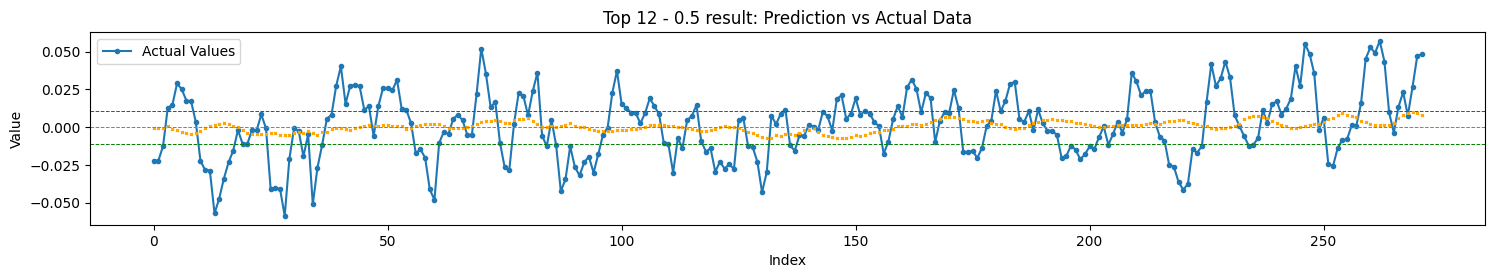

Total TH Pred.: 0


Top 13 - 0.5
RMSE: 0.021995, STD_DEV: 0.022002, STD_PRD: 0.002435, OBJDIFF: 0.004885, RDIFF: -0.000007
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 75, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022324, inv. diff> 0.010106
Trend accuracy       : 51.095
Trend up accuracy    : 76.552
Trend down accuracy  : 22.481


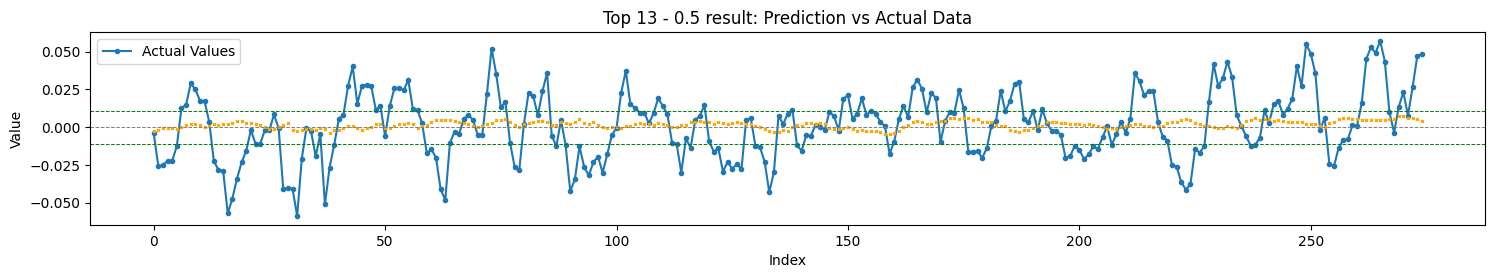

Total TH Pred.: 0


Top 14 - 0.5
RMSE: 0.028833, STD_DEV: 0.022002, STD_PRD: 0.020668, OBJDIFF: 0.007498, RDIFF: 0.006831
batch_size: 64, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 75, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.HeNormal object at 0x7495c47879a0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.030244, inv. diff> 0.008909
Trend accuracy       : 55.720
Trend up accuracy    : 55.862
Trend down accuracy  : 55.556


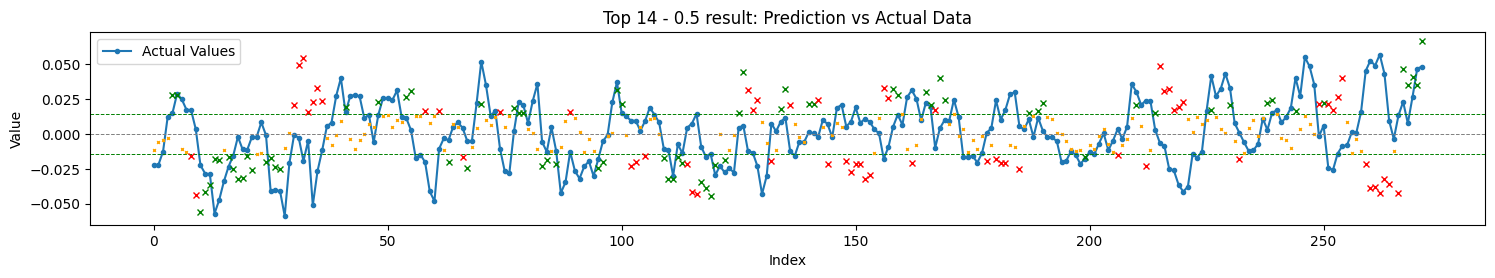

Total TH Pred.: 136
TH Pred. acc. : 53.68


Top 15 - 0.5
RMSE: 0.026621, STD_DEV: 0.021968, STD_PRD: 0.016179, OBJDIFF: 0.007547, RDIFF: 0.004653
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.HeNormal object at 0x7495c47879a0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.027305, inv. diff> 0.008231
Trend accuracy       : 52.727
Trend up accuracy    : 49.315
Trend down accuracy  : 56.589


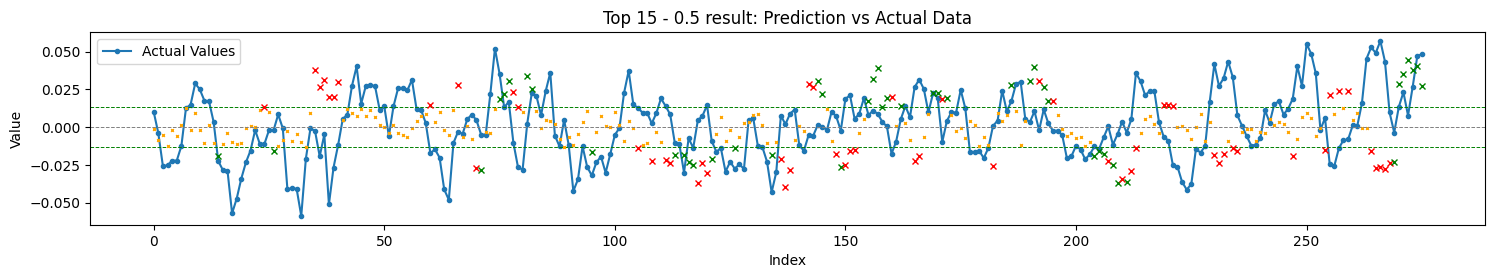

Total TH Pred.: 103
TH Pred. acc. : 44.66


Top 1 - 0.6
RMSE: 0.021396, STD_DEV: 0.021968, STD_PRD: 0.007593, OBJDIFF: 0.003022, RDIFF: -0.000572
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023853, inv. diff> 0.009073
Trend accuracy       : 59.273
Trend up accuracy    : 76.712
Trend down accuracy  : 39.535


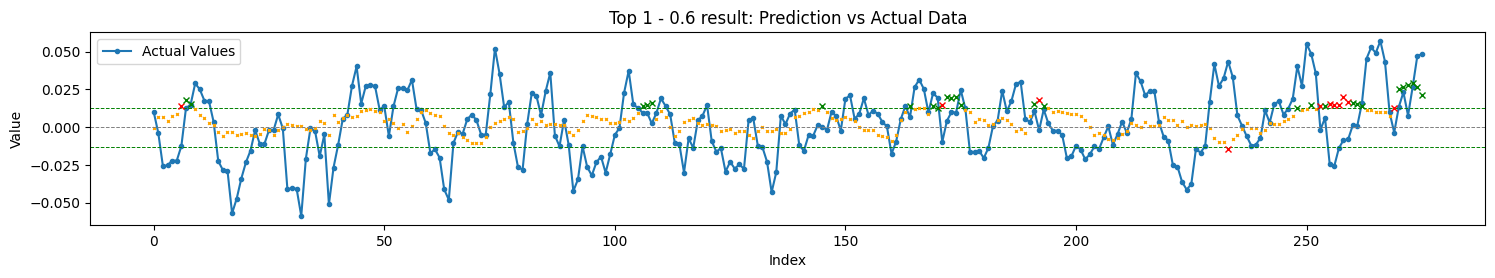

Total TH Pred.: 38
TH Pred. acc. : 71.05


Top 2 - 0.6
RMSE: 0.021314, STD_DEV: 0.022002, STD_PRD: 0.006986, OBJDIFF: 0.003066, RDIFF: -0.000688
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023377, inv. diff> 0.008883
Trend accuracy       : 53.650
Trend up accuracy    : 69.655
Trend down accuracy  : 35.659


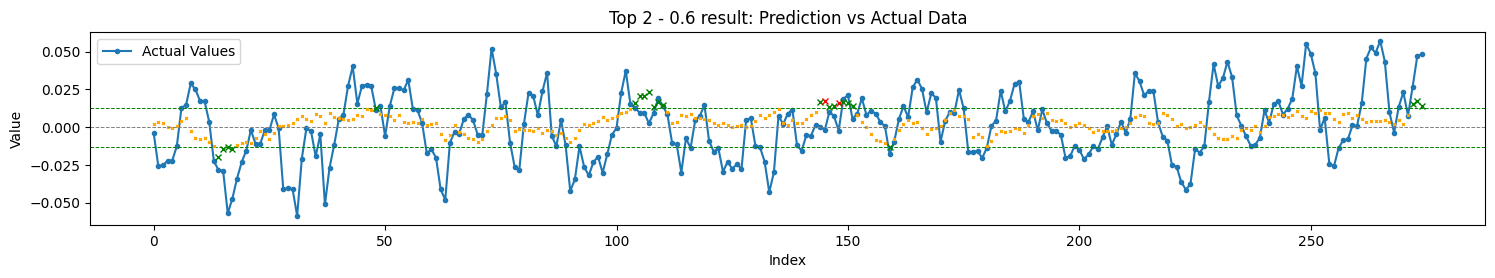

Total TH Pred.: 24
TH Pred. acc. : 91.67


Top 3 - 0.6
RMSE: 0.021549, STD_DEV: 0.022002, STD_PRD: 0.007305, OBJDIFF: 0.003222, RDIFF: -0.000452
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023508, inv. diff> 0.008855
Trend accuracy       : 59.124
Trend up accuracy    : 69.655
Trend down accuracy  : 47.287


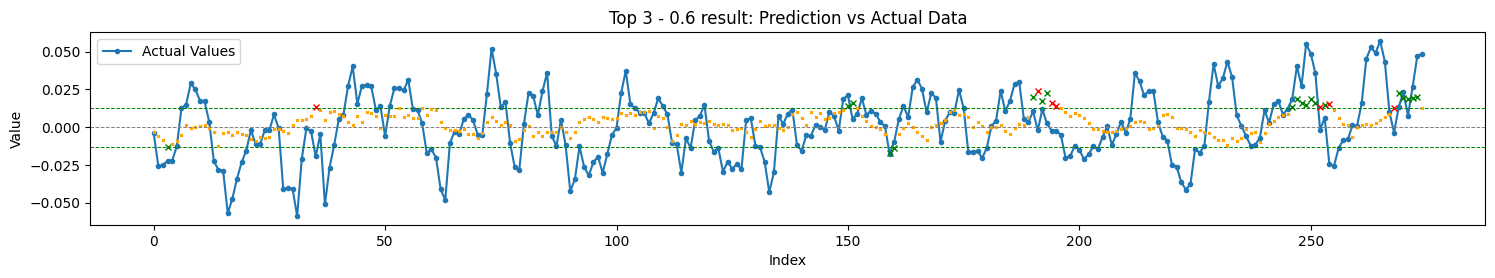

Total TH Pred.: 27
TH Pred. acc. : 74.07


Top 4 - 0.6
RMSE: 0.021346, STD_DEV: 0.022002, STD_PRD: 0.005851, OBJDIFF: 0.003382, RDIFF: -0.000656
batch_size: 64, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023008, inv. diff> 0.009081
Trend accuracy       : 57.934
Trend up accuracy    : 73.103
Trend down accuracy  : 40.476


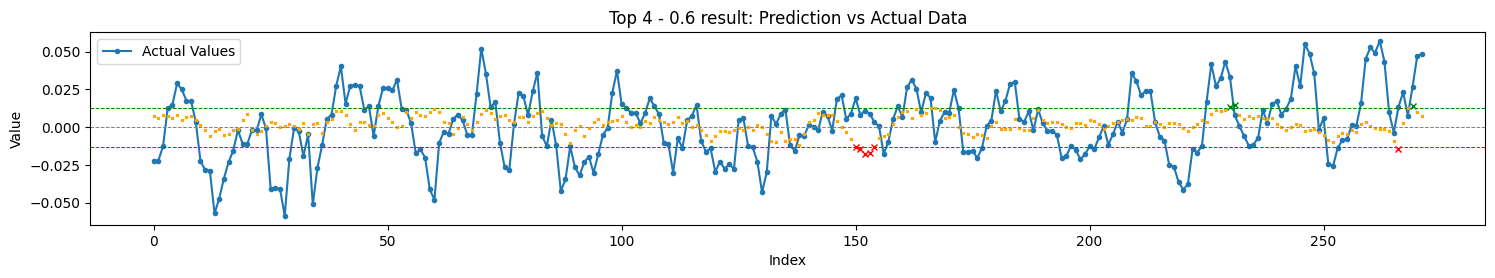

Total TH Pred.: 9
TH Pred. acc. : 33.33


Top 5 - 0.6
RMSE: 0.021730, STD_DEV: 0.021968, STD_PRD: 0.007309, OBJDIFF: 0.003427, RDIFF: -0.000238
batch_size: 64, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023367, inv. diff> 0.008729
Trend accuracy       : 58.909
Trend up accuracy    : 70.548
Trend down accuracy  : 45.736


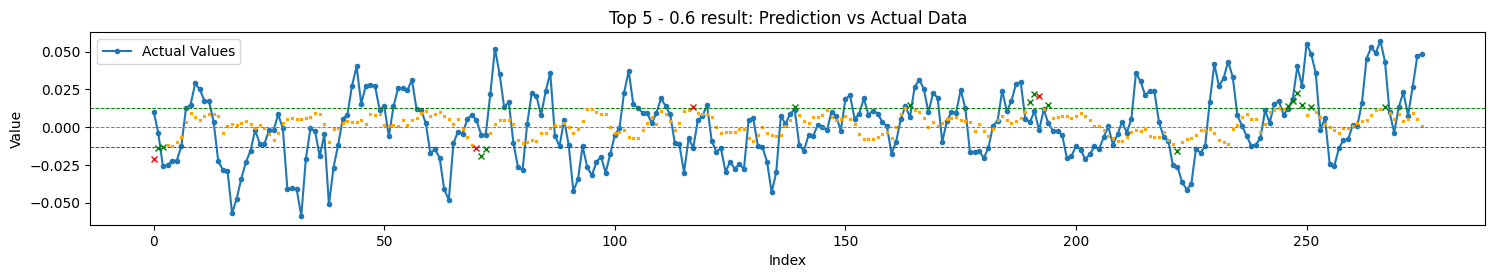

Total TH Pred.: 20
TH Pred. acc. : 80.00


Top 6 - 0.6
RMSE: 0.021968, STD_DEV: 0.021968, STD_PRD: 0.006441, OBJDIFF: 0.003881, RDIFF: -0.000001
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023266, inv. diff> 0.009062
Trend accuracy       : 56.364
Trend up accuracy    : 71.918
Trend down accuracy  : 38.760


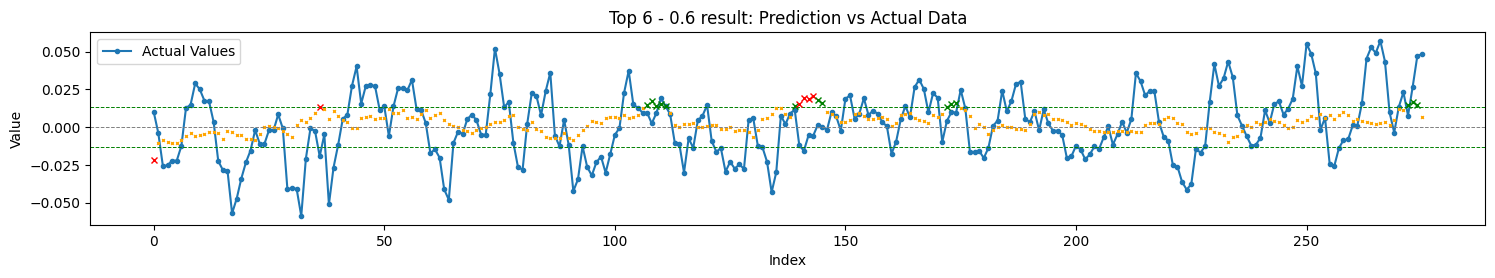

Total TH Pred.: 20
TH Pred. acc. : 70.00


Top 7 - 0.6
RMSE: 0.021253, STD_DEV: 0.021968, STD_PRD: 0.003182, OBJDIFF: 0.003981, RDIFF: -0.000715
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022365, inv. diff> 0.009790
Trend accuracy       : 53.455
Trend up accuracy    : 70.548
Trend down accuracy  : 34.109


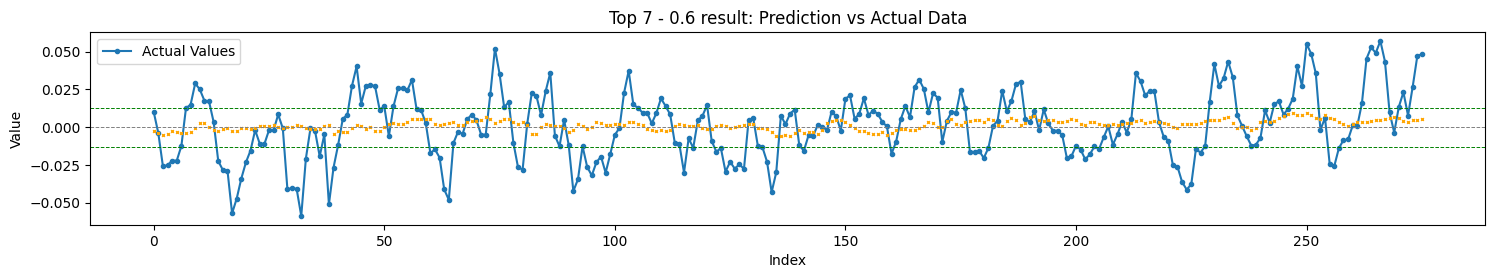

Total TH Pred.: 0


Top 8 - 0.6
RMSE: 0.021928, STD_DEV: 0.022002, STD_PRD: 0.005410, OBJDIFF: 0.004074, RDIFF: -0.000074
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 75, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022877, inv. diff> 0.009171
Trend accuracy       : 52.030
Trend up accuracy    : 64.828
Trend down accuracy  : 37.302


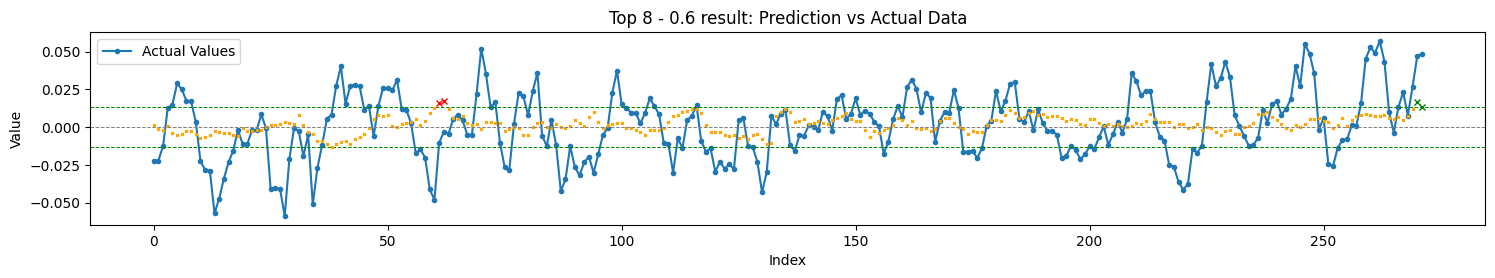

Total TH Pred.: 4
TH Pred. acc. : 50.00


Top 9 - 0.6
RMSE: 0.021642, STD_DEV: 0.022002, STD_PRD: 0.003914, OBJDIFF: 0.004162, RDIFF: -0.000359
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022384, inv. diff> 0.009426
Trend accuracy       : 57.934
Trend up accuracy    : 57.931
Trend down accuracy  : 57.937


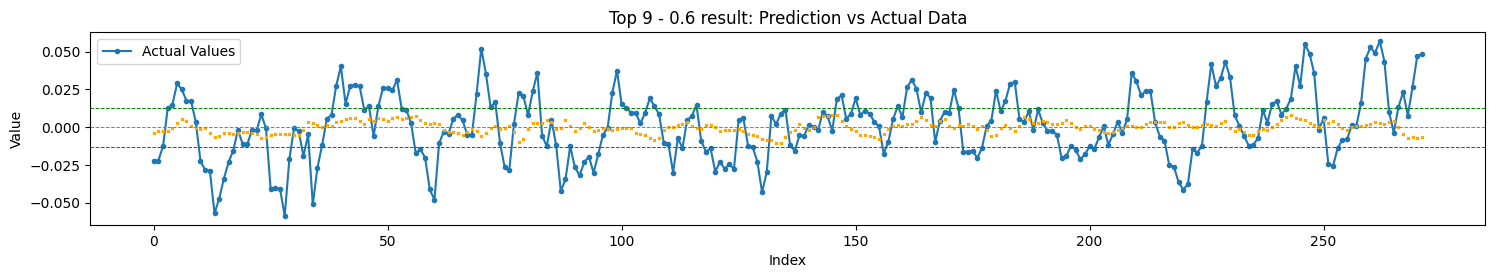

Total TH Pred.: 0


Top 10 - 0.6
RMSE: 0.021897, STD_DEV: 0.021968, STD_PRD: 0.003949, OBJDIFF: 0.004433, RDIFF: -0.000072
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022321, inv. diff> 0.009362
Trend accuracy       : 52.364
Trend up accuracy    : 39.041
Trend down accuracy  : 67.442


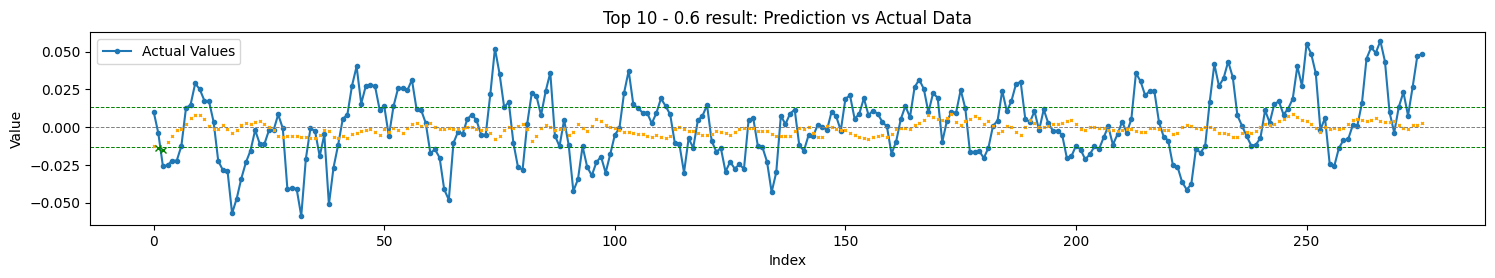

Total TH Pred.: 2
TH Pred. acc. : 100.00


Top 11 - 0.6
RMSE: 0.021910, STD_DEV: 0.021968, STD_PRD: 0.003931, OBJDIFF: 0.004451, RDIFF: -0.000059
batch_size: 64, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022419, inv. diff> 0.009469
Trend accuracy       : 49.455
Trend up accuracy    : 63.014
Trend down accuracy  : 34.109


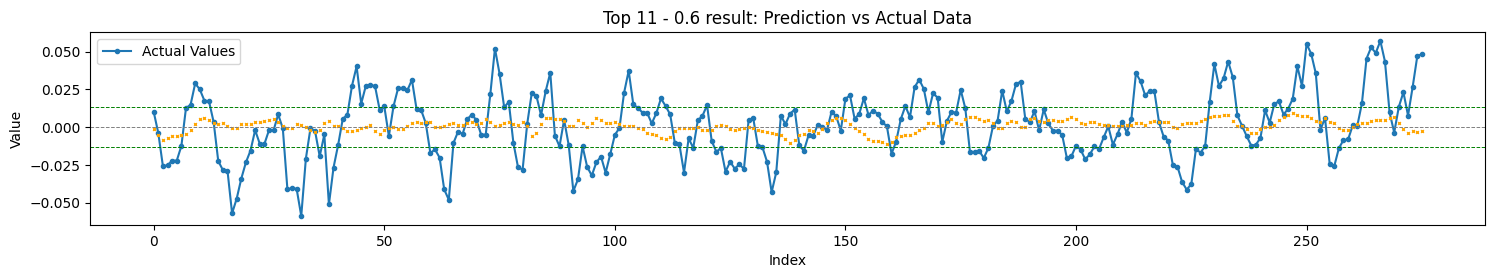

Total TH Pred.: 0


Top 12 - 0.6
RMSE: 0.021988, STD_DEV: 0.022002, STD_PRD: 0.003545, OBJDIFF: 0.004601, RDIFF: -0.000014
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 75, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022379, inv. diff> 0.009605
Trend accuracy       : 47.601
Trend up accuracy    : 57.241
Trend down accuracy  : 36.508


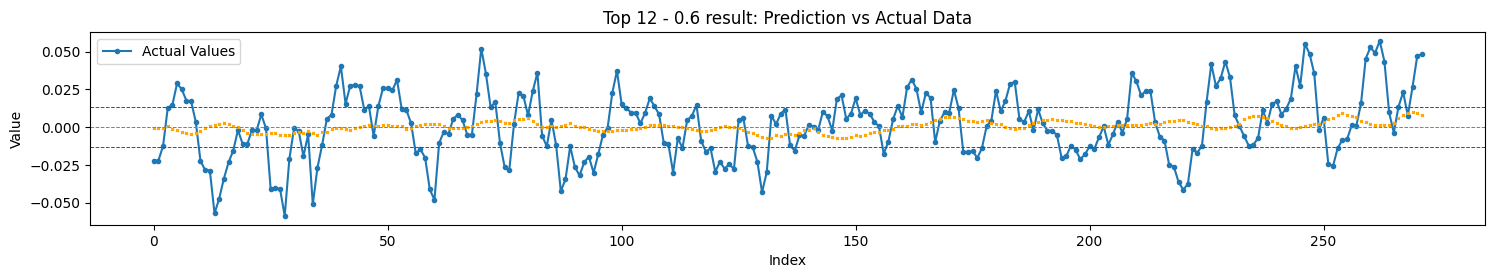

Total TH Pred.: 0


Top 13 - 0.6
RMSE: 0.021995, STD_DEV: 0.022002, STD_PRD: 0.002435, OBJDIFF: 0.004885, RDIFF: -0.000007
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 75, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022324, inv. diff> 0.010106
Trend accuracy       : 51.095
Trend up accuracy    : 76.552
Trend down accuracy  : 22.481


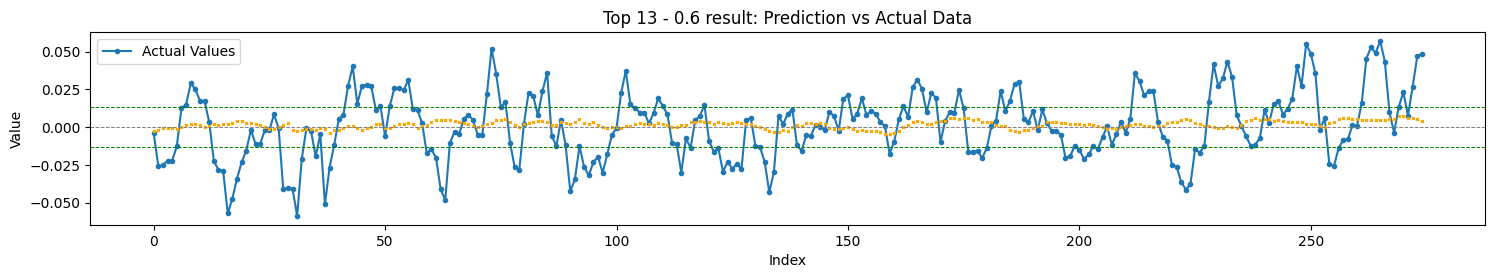

Total TH Pred.: 0


Top 14 - 0.6
RMSE: 0.028833, STD_DEV: 0.022002, STD_PRD: 0.020668, OBJDIFF: 0.007498, RDIFF: 0.006831
batch_size: 64, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 75, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.HeNormal object at 0x7495c47879a0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.030244, inv. diff> 0.008909
Trend accuracy       : 55.720
Trend up accuracy    : 55.862
Trend down accuracy  : 55.556


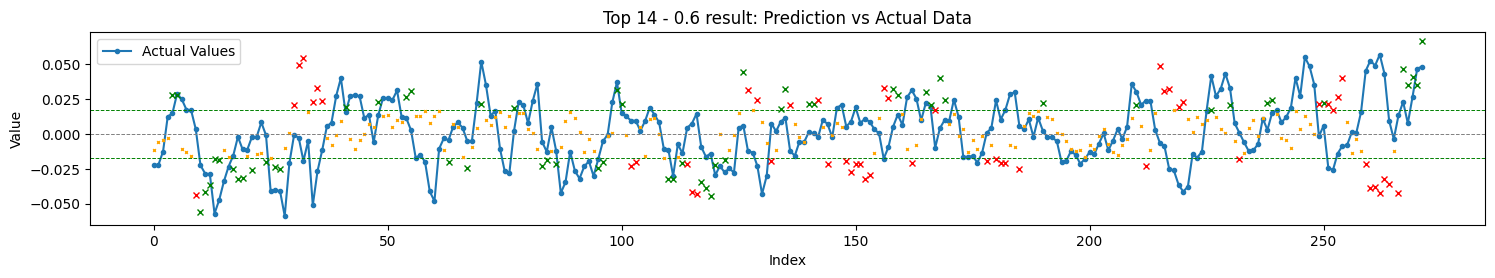

Total TH Pred.: 112
TH Pred. acc. : 53.57


Top 15 - 0.6
RMSE: 0.026621, STD_DEV: 0.021968, STD_PRD: 0.016179, OBJDIFF: 0.007547, RDIFF: 0.004653
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.HeNormal object at 0x7495c47879a0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.027305, inv. diff> 0.008231
Trend accuracy       : 52.727
Trend up accuracy    : 49.315
Trend down accuracy  : 56.589


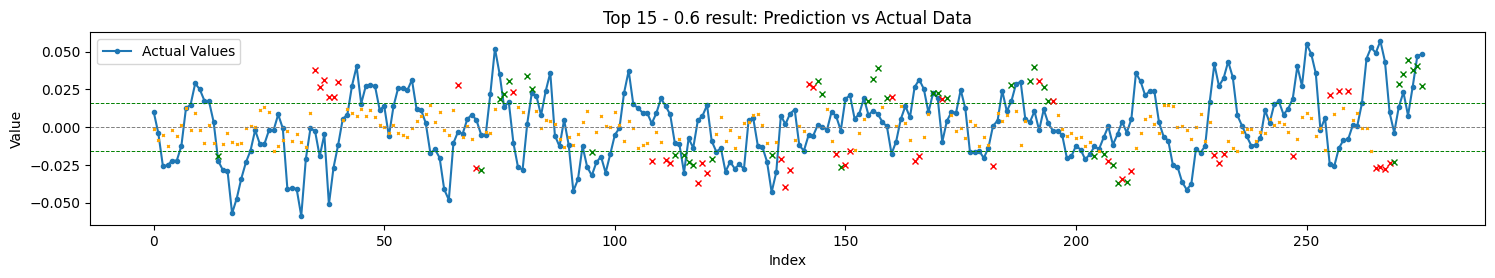

Total TH Pred.: 85
TH Pred. acc. : 48.24


Top 1 - 0.7
RMSE: 0.021396, STD_DEV: 0.021968, STD_PRD: 0.007593, OBJDIFF: 0.003022, RDIFF: -0.000572
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023853, inv. diff> 0.009073
Trend accuracy       : 59.273
Trend up accuracy    : 76.712
Trend down accuracy  : 39.535


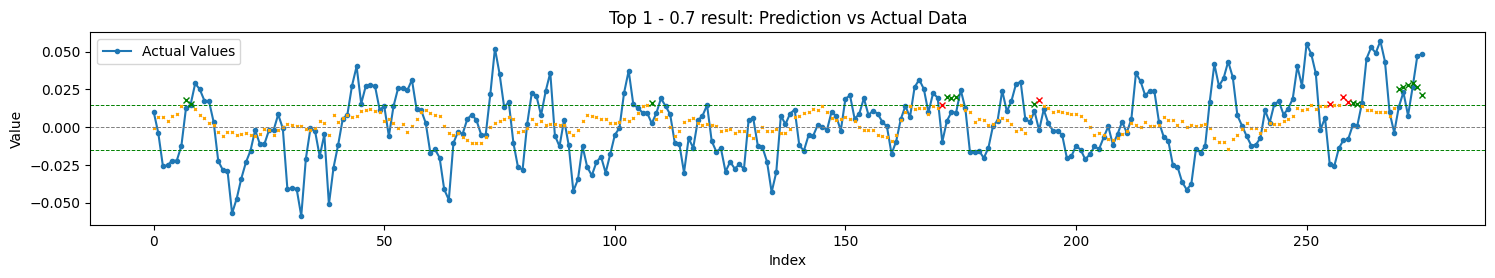

Total TH Pred.: 20
TH Pred. acc. : 75.00


Top 2 - 0.7
RMSE: 0.021314, STD_DEV: 0.022002, STD_PRD: 0.006986, OBJDIFF: 0.003066, RDIFF: -0.000688
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023377, inv. diff> 0.008883
Trend accuracy       : 53.650
Trend up accuracy    : 69.655
Trend down accuracy  : 35.659


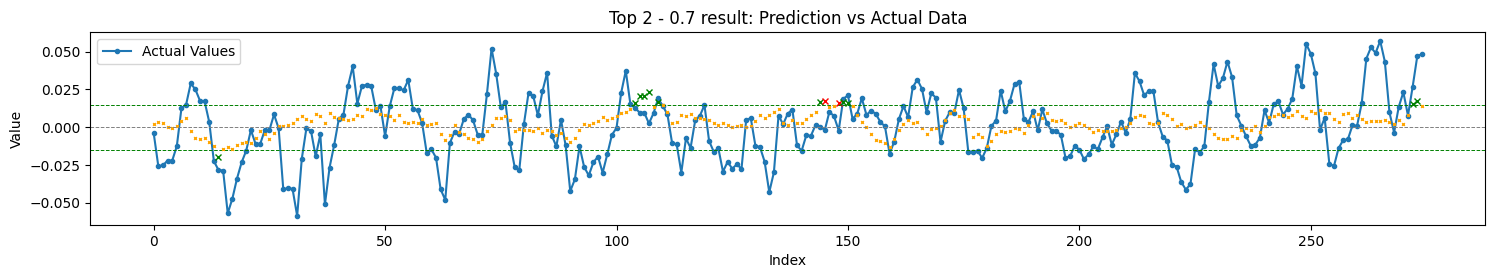

Total TH Pred.: 13
TH Pred. acc. : 84.62


Top 3 - 0.7
RMSE: 0.021549, STD_DEV: 0.022002, STD_PRD: 0.007305, OBJDIFF: 0.003222, RDIFF: -0.000452
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023508, inv. diff> 0.008855
Trend accuracy       : 59.124
Trend up accuracy    : 69.655
Trend down accuracy  : 47.287


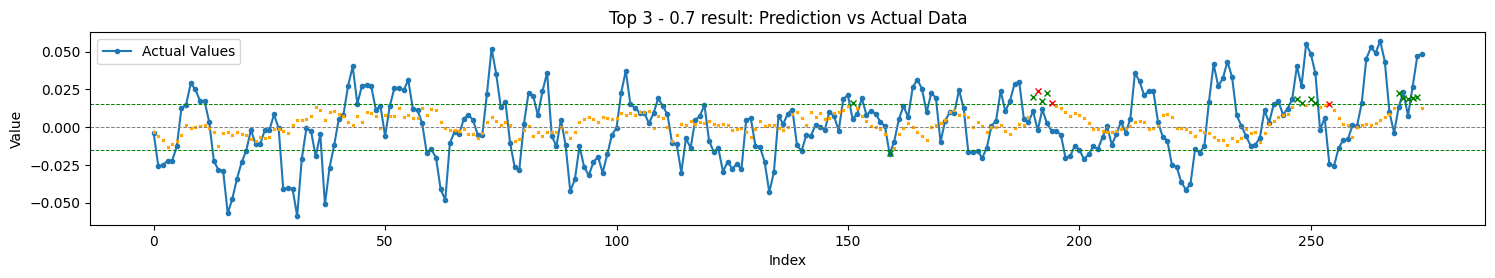

Total TH Pred.: 17
TH Pred. acc. : 82.35


Top 4 - 0.7
RMSE: 0.021346, STD_DEV: 0.022002, STD_PRD: 0.005851, OBJDIFF: 0.003382, RDIFF: -0.000656
batch_size: 64, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023008, inv. diff> 0.009081
Trend accuracy       : 57.934
Trend up accuracy    : 73.103
Trend down accuracy  : 40.476


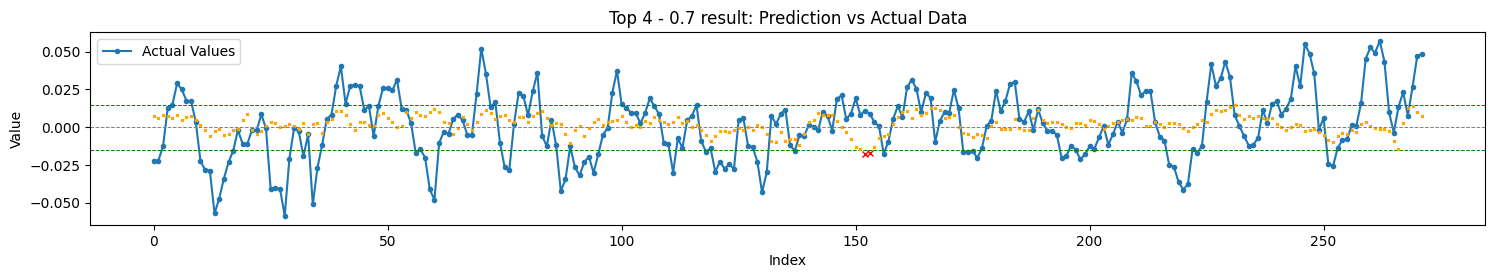

Total TH Pred.: 2
TH Pred. acc. : 0.00


Top 5 - 0.7
RMSE: 0.021730, STD_DEV: 0.021968, STD_PRD: 0.007309, OBJDIFF: 0.003427, RDIFF: -0.000238
batch_size: 64, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023367, inv. diff> 0.008729
Trend accuracy       : 58.909
Trend up accuracy    : 70.548
Trend down accuracy  : 45.736


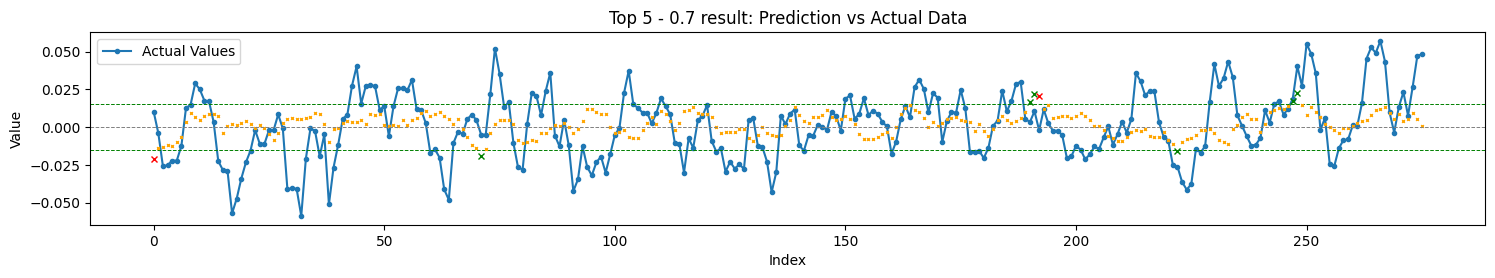

Total TH Pred.: 8
TH Pred. acc. : 75.00


Top 6 - 0.7
RMSE: 0.021968, STD_DEV: 0.021968, STD_PRD: 0.006441, OBJDIFF: 0.003881, RDIFF: -0.000001
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023266, inv. diff> 0.009062
Trend accuracy       : 56.364
Trend up accuracy    : 71.918
Trend down accuracy  : 38.760


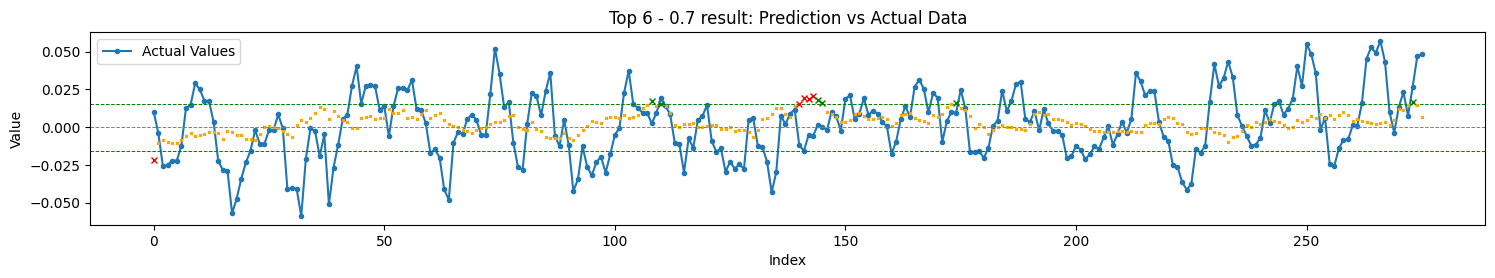

Total TH Pred.: 11
TH Pred. acc. : 54.55


Top 7 - 0.7
RMSE: 0.021253, STD_DEV: 0.021968, STD_PRD: 0.003182, OBJDIFF: 0.003981, RDIFF: -0.000715
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022365, inv. diff> 0.009790
Trend accuracy       : 53.455
Trend up accuracy    : 70.548
Trend down accuracy  : 34.109


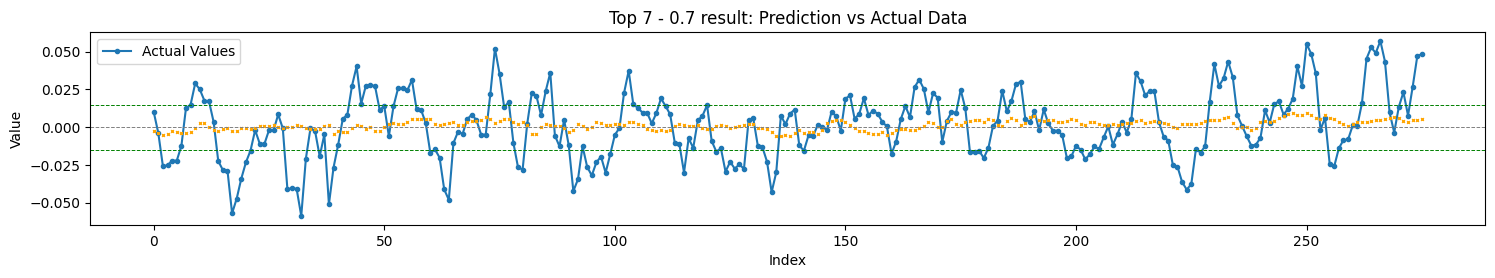

Total TH Pred.: 0


Top 8 - 0.7
RMSE: 0.021928, STD_DEV: 0.022002, STD_PRD: 0.005410, OBJDIFF: 0.004074, RDIFF: -0.000074
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 75, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022877, inv. diff> 0.009171
Trend accuracy       : 52.030
Trend up accuracy    : 64.828
Trend down accuracy  : 37.302


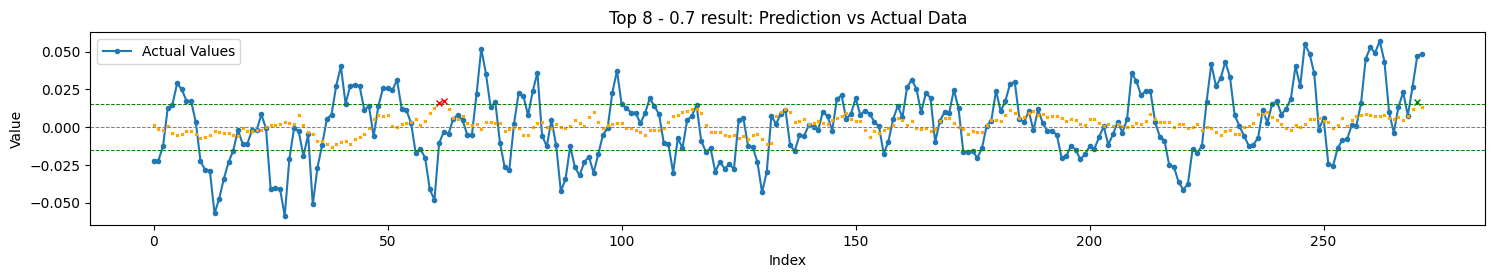

Total TH Pred.: 3
TH Pred. acc. : 33.33


Top 9 - 0.7
RMSE: 0.021642, STD_DEV: 0.022002, STD_PRD: 0.003914, OBJDIFF: 0.004162, RDIFF: -0.000359
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022384, inv. diff> 0.009426
Trend accuracy       : 57.934
Trend up accuracy    : 57.931
Trend down accuracy  : 57.937


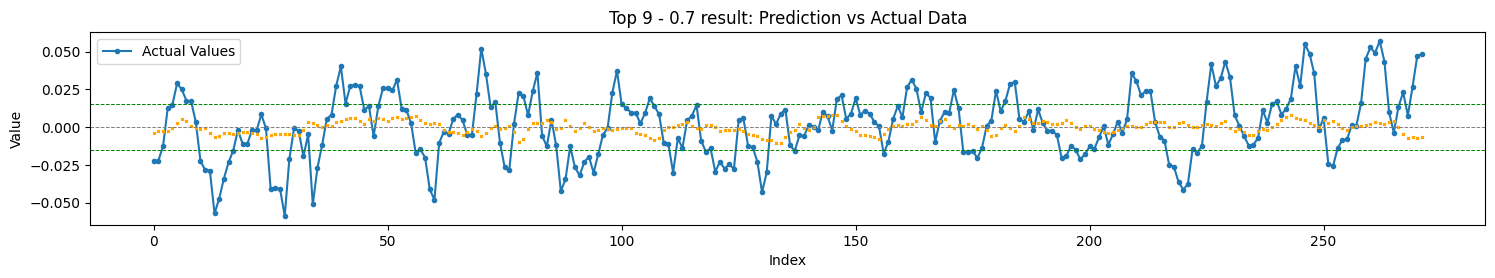

Total TH Pred.: 0


Top 10 - 0.7
RMSE: 0.021897, STD_DEV: 0.021968, STD_PRD: 0.003949, OBJDIFF: 0.004433, RDIFF: -0.000072
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022321, inv. diff> 0.009362
Trend accuracy       : 52.364
Trend up accuracy    : 39.041
Trend down accuracy  : 67.442


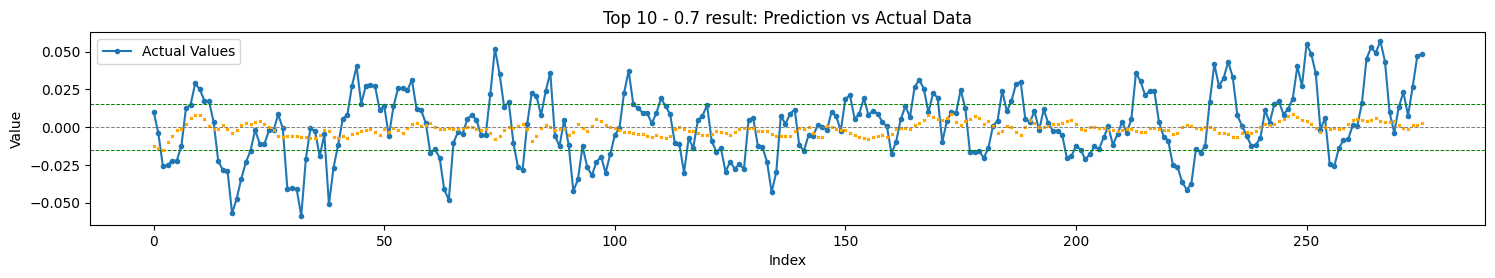

Total TH Pred.: 0


Top 11 - 0.7
RMSE: 0.021910, STD_DEV: 0.021968, STD_PRD: 0.003931, OBJDIFF: 0.004451, RDIFF: -0.000059
batch_size: 64, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022419, inv. diff> 0.009469
Trend accuracy       : 49.455
Trend up accuracy    : 63.014
Trend down accuracy  : 34.109


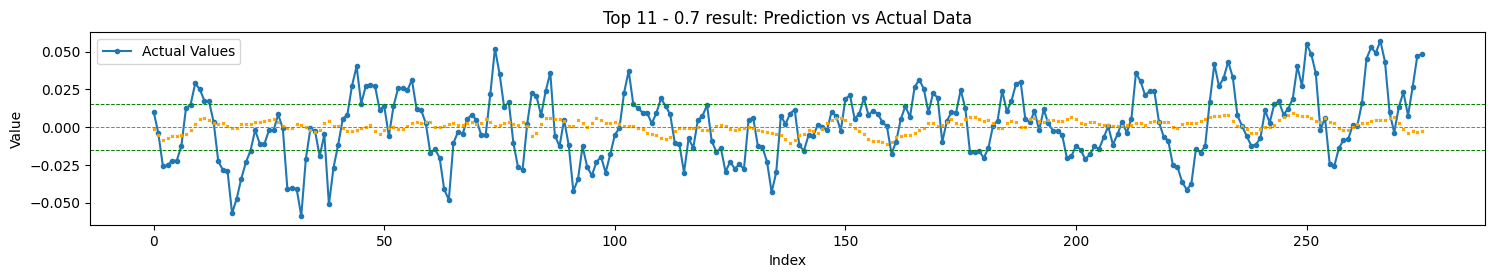

Total TH Pred.: 0


Top 12 - 0.7
RMSE: 0.021988, STD_DEV: 0.022002, STD_PRD: 0.003545, OBJDIFF: 0.004601, RDIFF: -0.000014
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 75, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022379, inv. diff> 0.009605
Trend accuracy       : 47.601
Trend up accuracy    : 57.241
Trend down accuracy  : 36.508


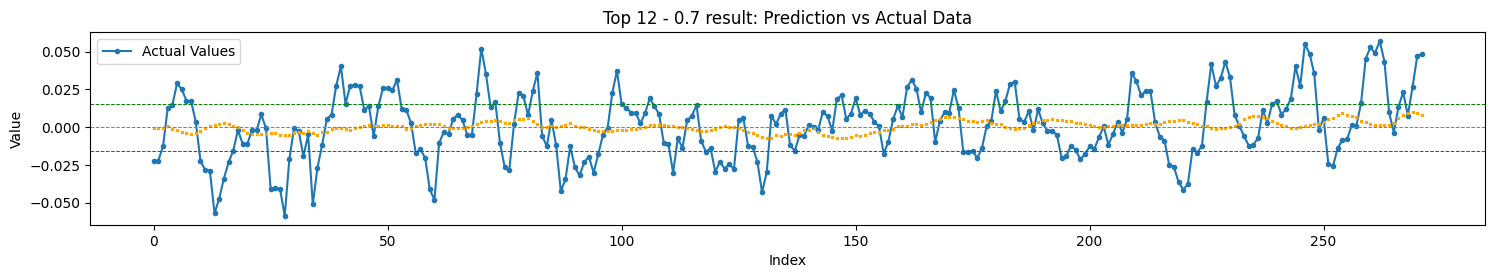

Total TH Pred.: 0


Top 13 - 0.7
RMSE: 0.021995, STD_DEV: 0.022002, STD_PRD: 0.002435, OBJDIFF: 0.004885, RDIFF: -0.000007
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 75, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022324, inv. diff> 0.010106
Trend accuracy       : 51.095
Trend up accuracy    : 76.552
Trend down accuracy  : 22.481


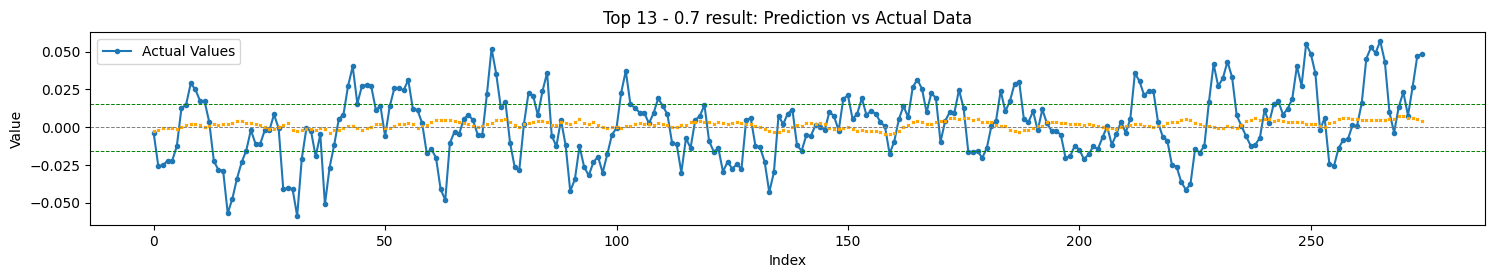

Total TH Pred.: 0


Top 14 - 0.7
RMSE: 0.028833, STD_DEV: 0.022002, STD_PRD: 0.020668, OBJDIFF: 0.007498, RDIFF: 0.006831
batch_size: 64, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 75, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.HeNormal object at 0x7495c47879a0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.030244, inv. diff> 0.008909
Trend accuracy       : 55.720
Trend up accuracy    : 55.862
Trend down accuracy  : 55.556


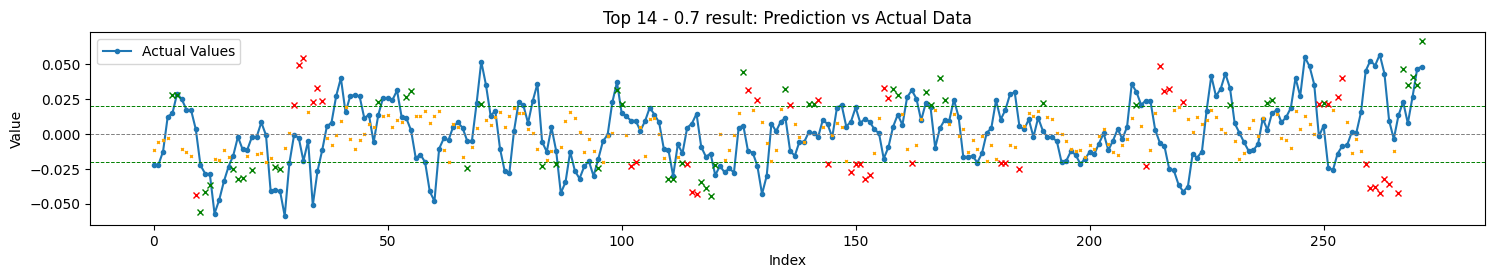

Total TH Pred.: 93
TH Pred. acc. : 52.69


Top 15 - 0.7
RMSE: 0.026621, STD_DEV: 0.021968, STD_PRD: 0.016179, OBJDIFF: 0.007547, RDIFF: 0.004653
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.HeNormal object at 0x7495c47879a0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.027305, inv. diff> 0.008231
Trend accuracy       : 52.727
Trend up accuracy    : 49.315
Trend down accuracy  : 56.589


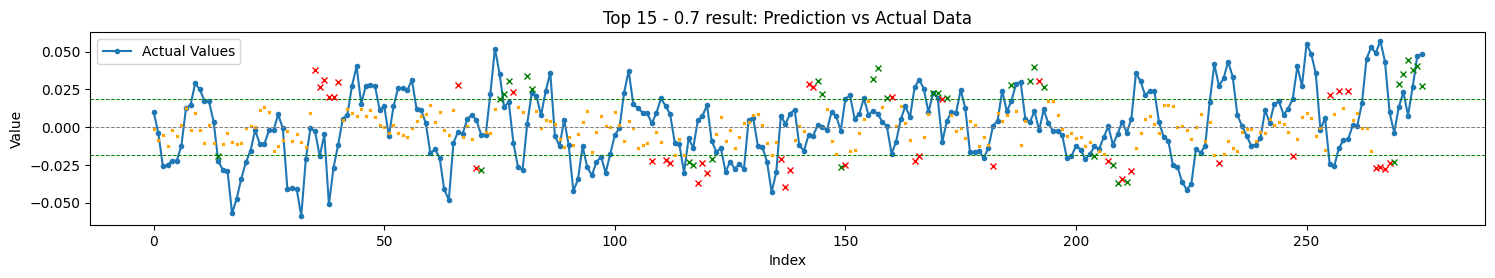

Total TH Pred.: 73
TH Pred. acc. : 46.58


Top 1 - 0.8
RMSE: 0.021396, STD_DEV: 0.021968, STD_PRD: 0.007593, OBJDIFF: 0.003022, RDIFF: -0.000572
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023853, inv. diff> 0.009073
Trend accuracy       : 59.273
Trend up accuracy    : 76.712
Trend down accuracy  : 39.535


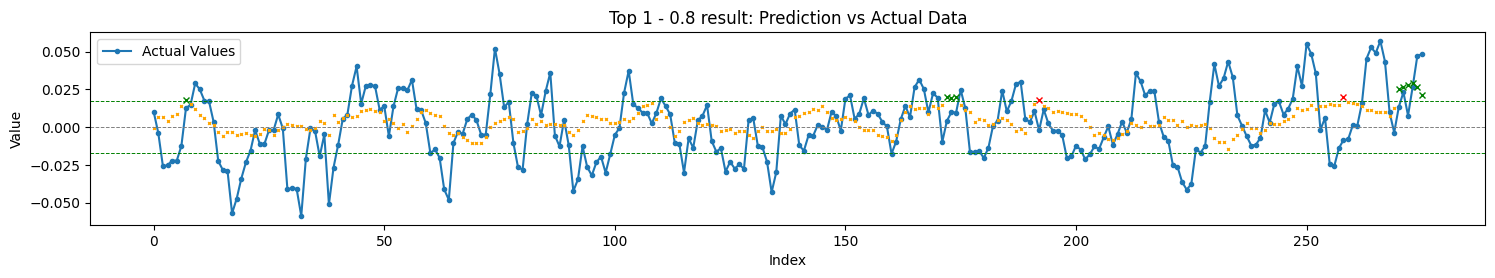

Total TH Pred.: 12
TH Pred. acc. : 83.33


Top 2 - 0.8
RMSE: 0.021314, STD_DEV: 0.022002, STD_PRD: 0.006986, OBJDIFF: 0.003066, RDIFF: -0.000688
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023377, inv. diff> 0.008883
Trend accuracy       : 53.650
Trend up accuracy    : 69.655
Trend down accuracy  : 35.659


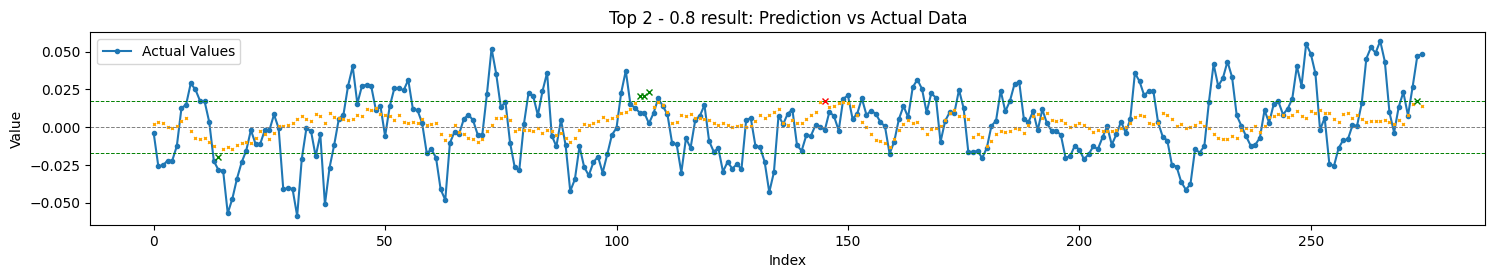

Total TH Pred.: 6
TH Pred. acc. : 83.33


Top 3 - 0.8
RMSE: 0.021549, STD_DEV: 0.022002, STD_PRD: 0.007305, OBJDIFF: 0.003222, RDIFF: -0.000452
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023508, inv. diff> 0.008855
Trend accuracy       : 59.124
Trend up accuracy    : 69.655
Trend down accuracy  : 47.287


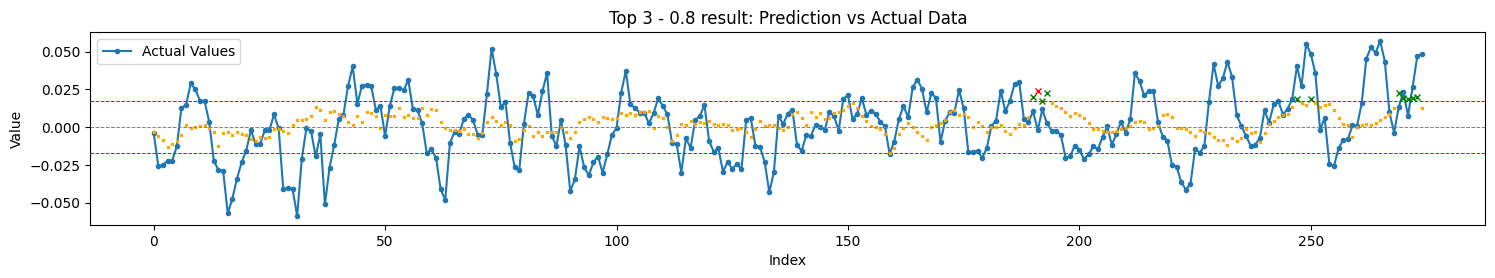

Total TH Pred.: 11
TH Pred. acc. : 90.91


Top 4 - 0.8
RMSE: 0.021346, STD_DEV: 0.022002, STD_PRD: 0.005851, OBJDIFF: 0.003382, RDIFF: -0.000656
batch_size: 64, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023008, inv. diff> 0.009081
Trend accuracy       : 57.934
Trend up accuracy    : 73.103
Trend down accuracy  : 40.476


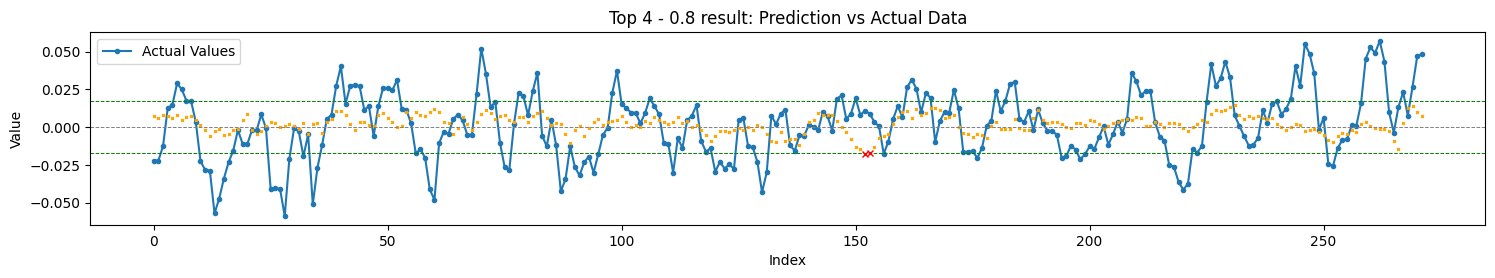

Total TH Pred.: 2
TH Pred. acc. : 0.00


Top 5 - 0.8
RMSE: 0.021730, STD_DEV: 0.021968, STD_PRD: 0.007309, OBJDIFF: 0.003427, RDIFF: -0.000238
batch_size: 64, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023367, inv. diff> 0.008729
Trend accuracy       : 58.909
Trend up accuracy    : 70.548
Trend down accuracy  : 45.736


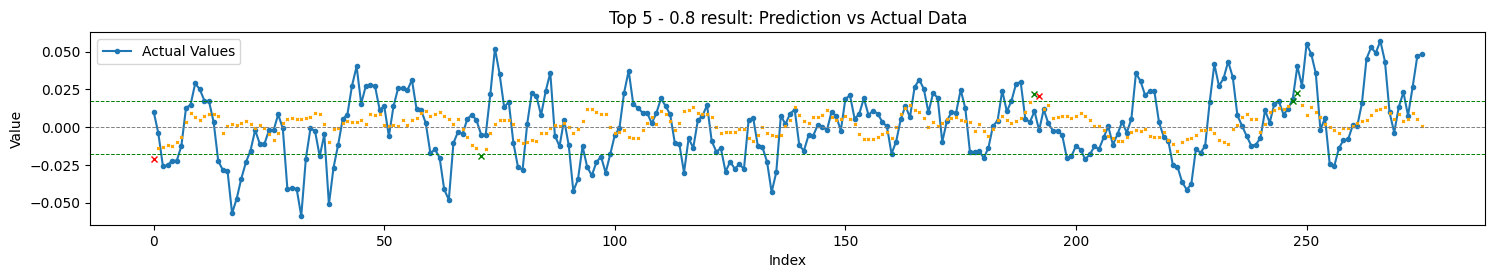

Total TH Pred.: 6
TH Pred. acc. : 66.67


Top 6 - 0.8
RMSE: 0.021968, STD_DEV: 0.021968, STD_PRD: 0.006441, OBJDIFF: 0.003881, RDIFF: -0.000001
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023266, inv. diff> 0.009062
Trend accuracy       : 56.364
Trend up accuracy    : 71.918
Trend down accuracy  : 38.760


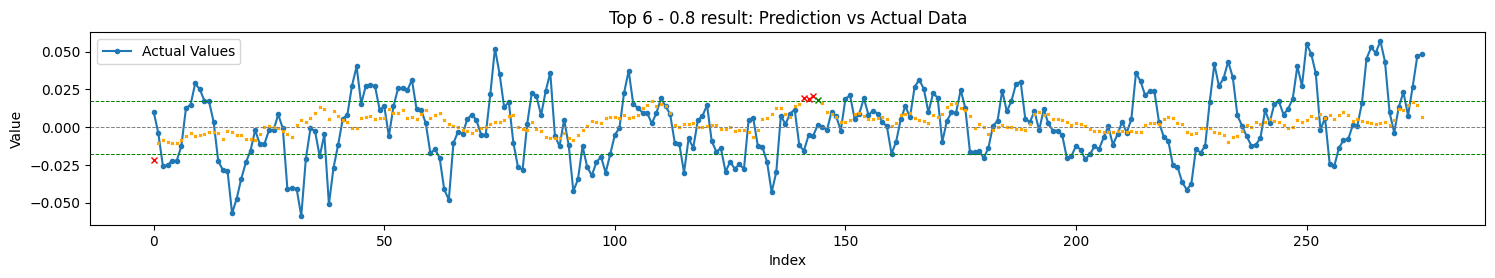

Total TH Pred.: 5
TH Pred. acc. : 20.00


Top 7 - 0.8
RMSE: 0.021253, STD_DEV: 0.021968, STD_PRD: 0.003182, OBJDIFF: 0.003981, RDIFF: -0.000715
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022365, inv. diff> 0.009790
Trend accuracy       : 53.455
Trend up accuracy    : 70.548
Trend down accuracy  : 34.109


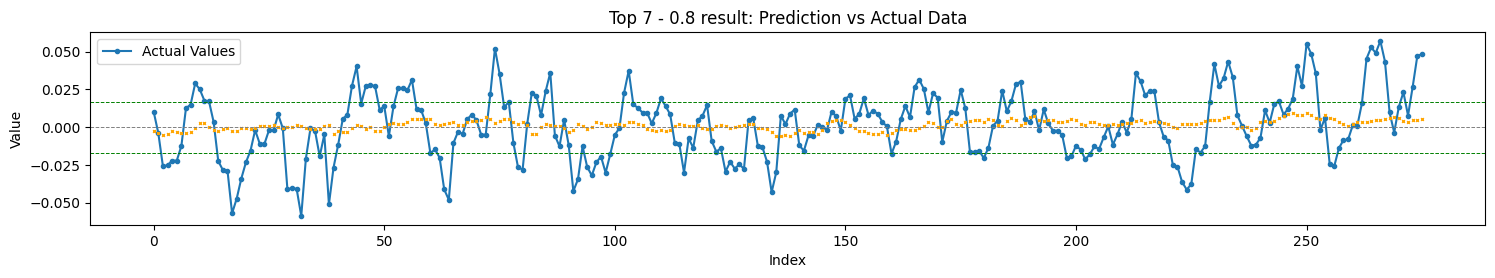

Total TH Pred.: 0


Top 8 - 0.8
RMSE: 0.021928, STD_DEV: 0.022002, STD_PRD: 0.005410, OBJDIFF: 0.004074, RDIFF: -0.000074
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 75, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022877, inv. diff> 0.009171
Trend accuracy       : 52.030
Trend up accuracy    : 64.828
Trend down accuracy  : 37.302


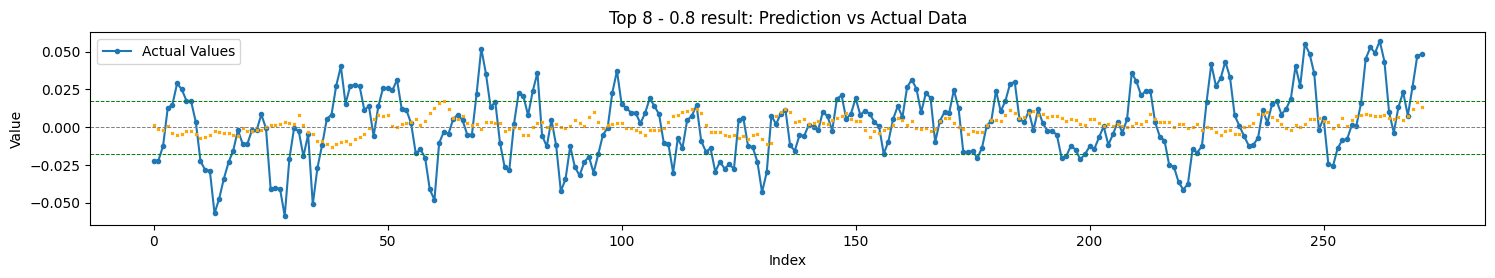

Total TH Pred.: 0


Top 9 - 0.8
RMSE: 0.021642, STD_DEV: 0.022002, STD_PRD: 0.003914, OBJDIFF: 0.004162, RDIFF: -0.000359
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022384, inv. diff> 0.009426
Trend accuracy       : 57.934
Trend up accuracy    : 57.931
Trend down accuracy  : 57.937


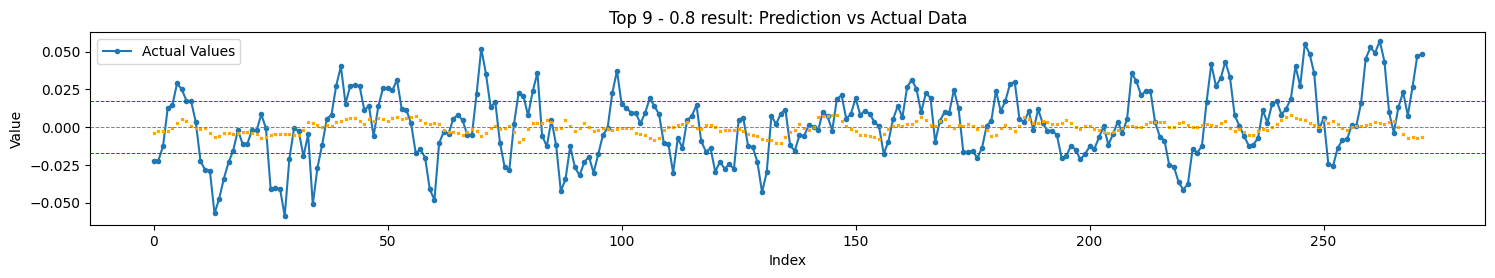

Total TH Pred.: 0


Top 10 - 0.8
RMSE: 0.021897, STD_DEV: 0.021968, STD_PRD: 0.003949, OBJDIFF: 0.004433, RDIFF: -0.000072
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022321, inv. diff> 0.009362
Trend accuracy       : 52.364
Trend up accuracy    : 39.041
Trend down accuracy  : 67.442


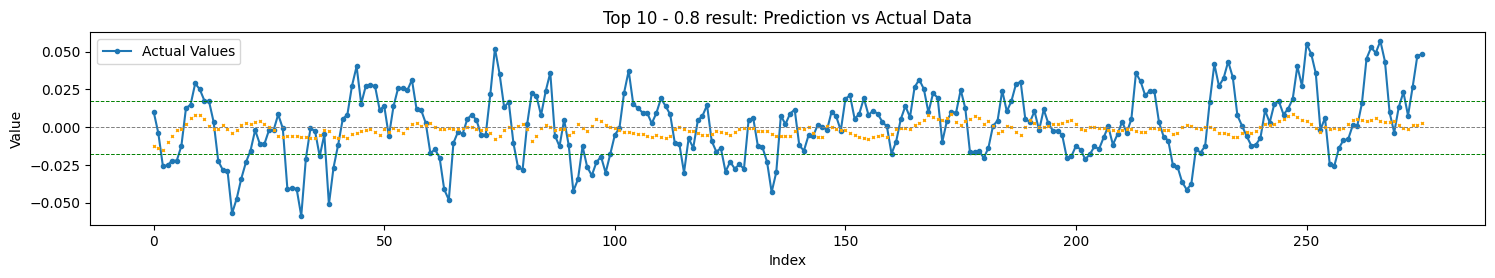

Total TH Pred.: 0


Top 11 - 0.8
RMSE: 0.021910, STD_DEV: 0.021968, STD_PRD: 0.003931, OBJDIFF: 0.004451, RDIFF: -0.000059
batch_size: 64, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022419, inv. diff> 0.009469
Trend accuracy       : 49.455
Trend up accuracy    : 63.014
Trend down accuracy  : 34.109


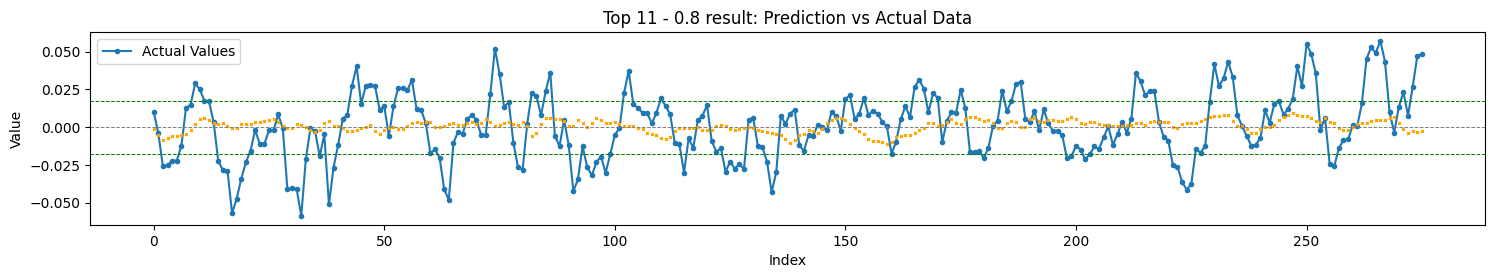

Total TH Pred.: 0


Top 12 - 0.8
RMSE: 0.021988, STD_DEV: 0.022002, STD_PRD: 0.003545, OBJDIFF: 0.004601, RDIFF: -0.000014
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 75, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022379, inv. diff> 0.009605
Trend accuracy       : 47.601
Trend up accuracy    : 57.241
Trend down accuracy  : 36.508


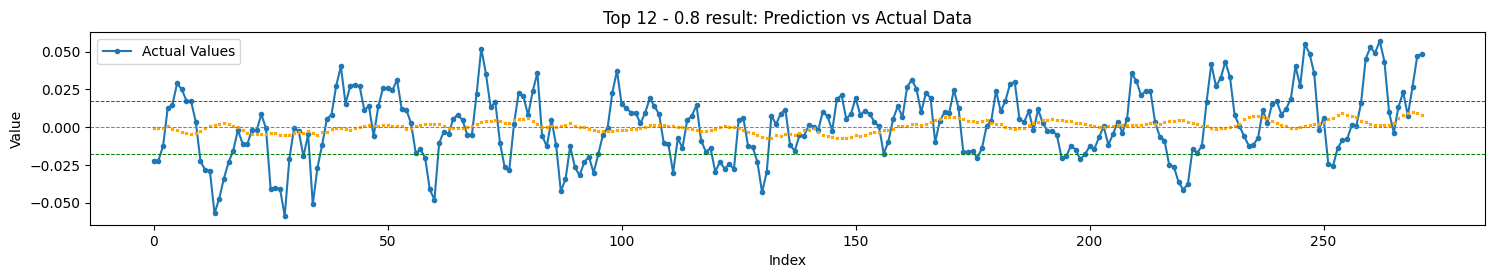

Total TH Pred.: 0


Top 13 - 0.8
RMSE: 0.021995, STD_DEV: 0.022002, STD_PRD: 0.002435, OBJDIFF: 0.004885, RDIFF: -0.000007
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 75, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022324, inv. diff> 0.010106
Trend accuracy       : 51.095
Trend up accuracy    : 76.552
Trend down accuracy  : 22.481


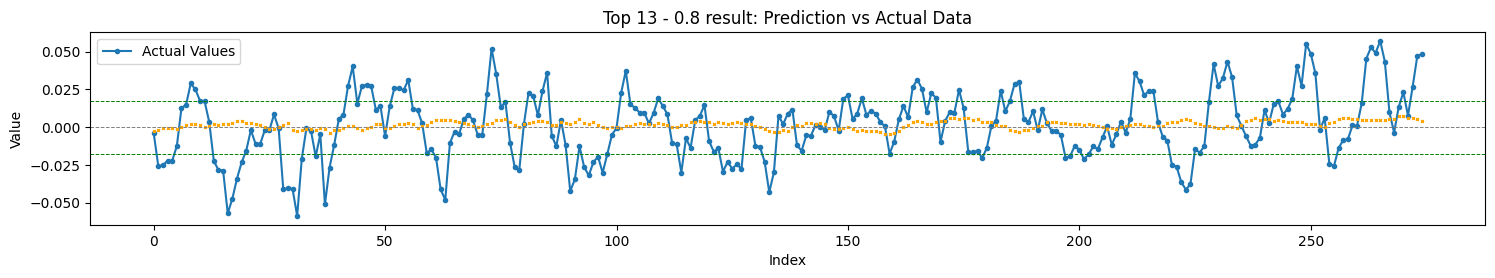

Total TH Pred.: 0


Top 14 - 0.8
RMSE: 0.028833, STD_DEV: 0.022002, STD_PRD: 0.020668, OBJDIFF: 0.007498, RDIFF: 0.006831
batch_size: 64, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 75, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.HeNormal object at 0x7495c47879a0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.030244, inv. diff> 0.008909
Trend accuracy       : 55.720
Trend up accuracy    : 55.862
Trend down accuracy  : 55.556


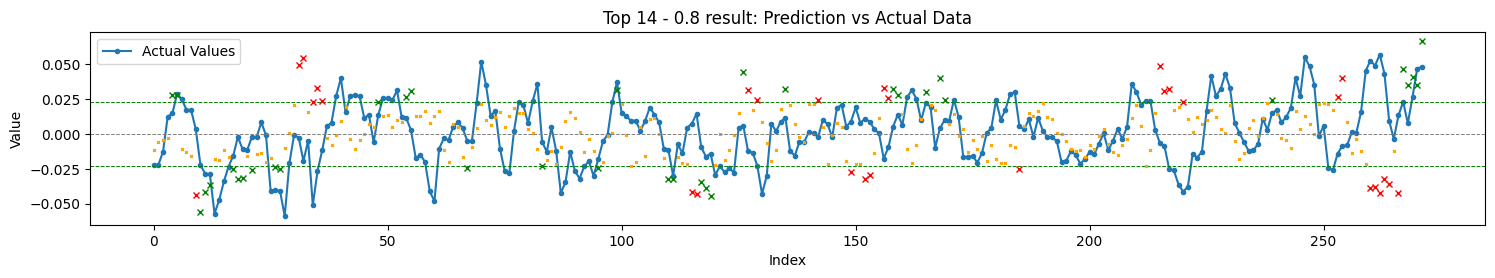

Total TH Pred.: 65
TH Pred. acc. : 55.38


Top 15 - 0.8
RMSE: 0.026621, STD_DEV: 0.021968, STD_PRD: 0.016179, OBJDIFF: 0.007547, RDIFF: 0.004653
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.HeNormal object at 0x7495c47879a0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.027305, inv. diff> 0.008231
Trend accuracy       : 52.727
Trend up accuracy    : 49.315
Trend down accuracy  : 56.589


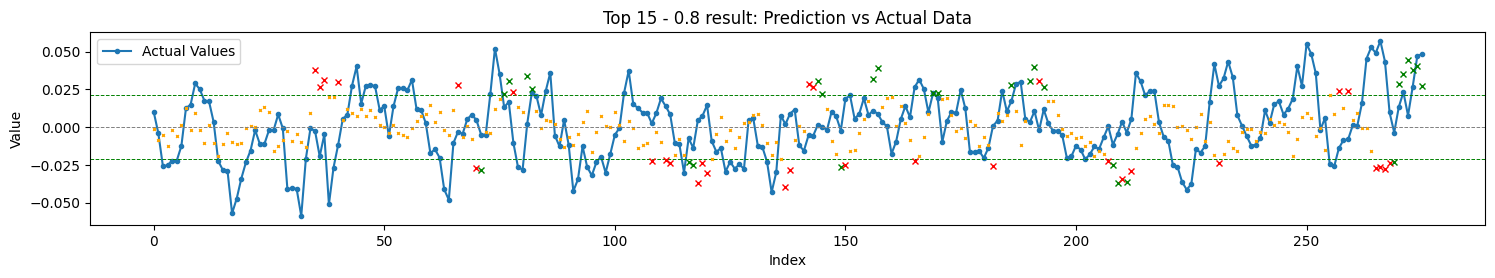

Total TH Pred.: 59
TH Pred. acc. : 47.46


Top 1 - 0.9
RMSE: 0.021396, STD_DEV: 0.021968, STD_PRD: 0.007593, OBJDIFF: 0.003022, RDIFF: -0.000572
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023853, inv. diff> 0.009073
Trend accuracy       : 59.273
Trend up accuracy    : 76.712
Trend down accuracy  : 39.535


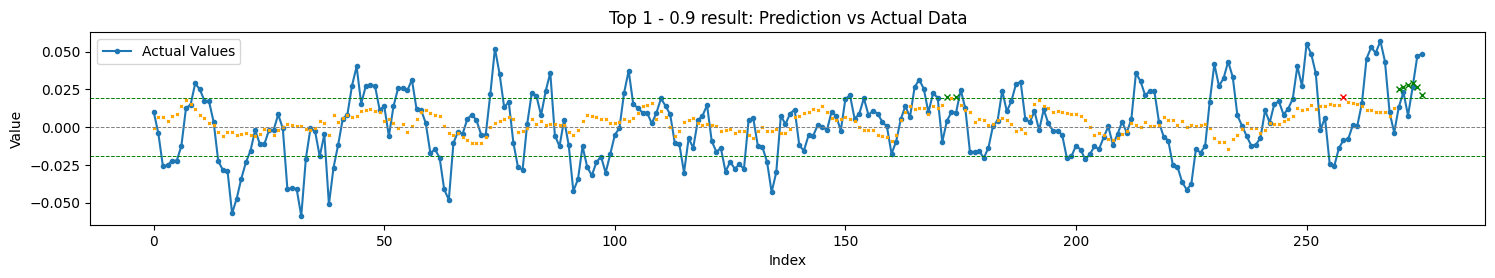

Total TH Pred.: 9
TH Pred. acc. : 88.89


Top 2 - 0.9
RMSE: 0.021314, STD_DEV: 0.022002, STD_PRD: 0.006986, OBJDIFF: 0.003066, RDIFF: -0.000688
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023377, inv. diff> 0.008883
Trend accuracy       : 53.650
Trend up accuracy    : 69.655
Trend down accuracy  : 35.659


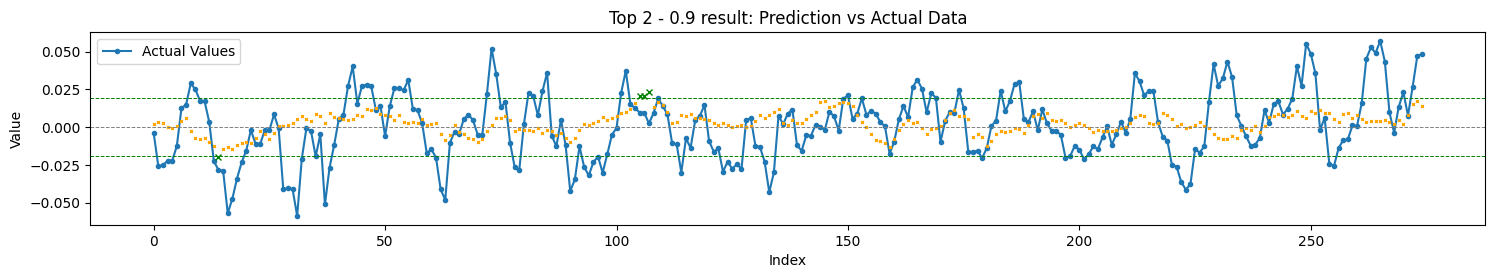

Total TH Pred.: 4
TH Pred. acc. : 100.00


Top 3 - 0.9
RMSE: 0.021549, STD_DEV: 0.022002, STD_PRD: 0.007305, OBJDIFF: 0.003222, RDIFF: -0.000452
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023508, inv. diff> 0.008855
Trend accuracy       : 59.124
Trend up accuracy    : 69.655
Trend down accuracy  : 47.287


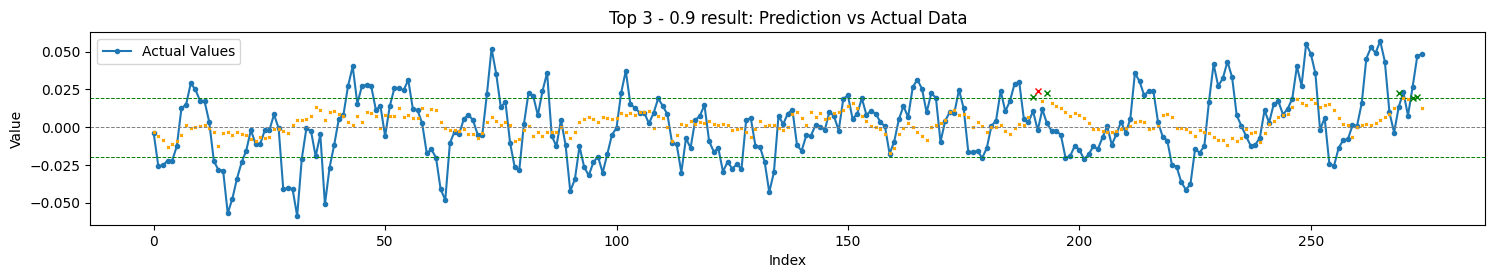

Total TH Pred.: 6
TH Pred. acc. : 83.33


Top 4 - 0.9
RMSE: 0.021346, STD_DEV: 0.022002, STD_PRD: 0.005851, OBJDIFF: 0.003382, RDIFF: -0.000656
batch_size: 64, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023008, inv. diff> 0.009081
Trend accuracy       : 57.934
Trend up accuracy    : 73.103
Trend down accuracy  : 40.476


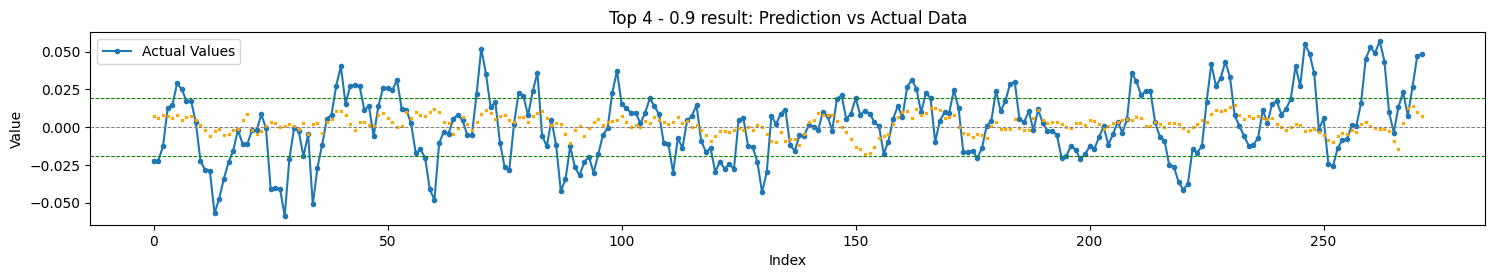

Total TH Pred.: 0


Top 5 - 0.9
RMSE: 0.021730, STD_DEV: 0.021968, STD_PRD: 0.007309, OBJDIFF: 0.003427, RDIFF: -0.000238
batch_size: 64, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023367, inv. diff> 0.008729
Trend accuracy       : 58.909
Trend up accuracy    : 70.548
Trend down accuracy  : 45.736


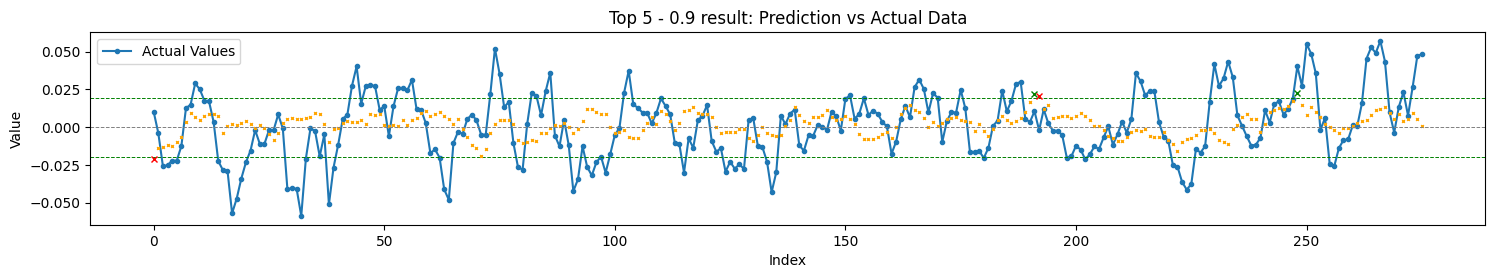

Total TH Pred.: 4
TH Pred. acc. : 50.00


Top 6 - 0.9
RMSE: 0.021968, STD_DEV: 0.021968, STD_PRD: 0.006441, OBJDIFF: 0.003881, RDIFF: -0.000001
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023266, inv. diff> 0.009062
Trend accuracy       : 56.364
Trend up accuracy    : 71.918
Trend down accuracy  : 38.760


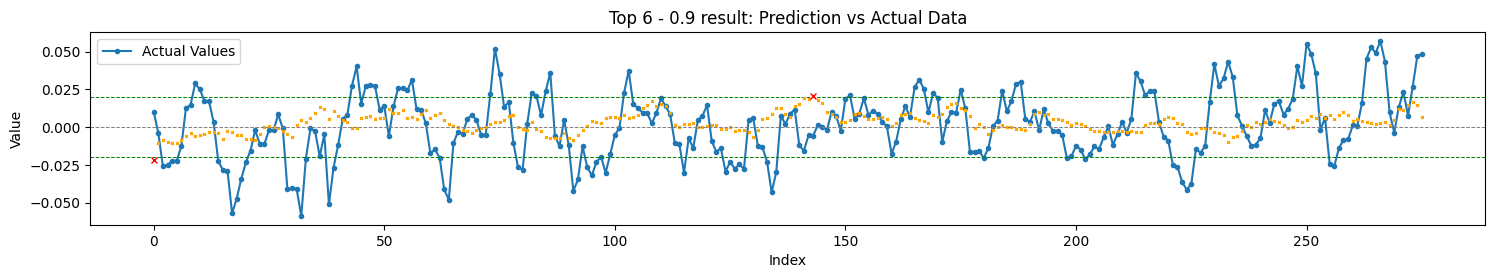

Total TH Pred.: 2
TH Pred. acc. : 0.00


Top 7 - 0.9
RMSE: 0.021253, STD_DEV: 0.021968, STD_PRD: 0.003182, OBJDIFF: 0.003981, RDIFF: -0.000715
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022365, inv. diff> 0.009790
Trend accuracy       : 53.455
Trend up accuracy    : 70.548
Trend down accuracy  : 34.109


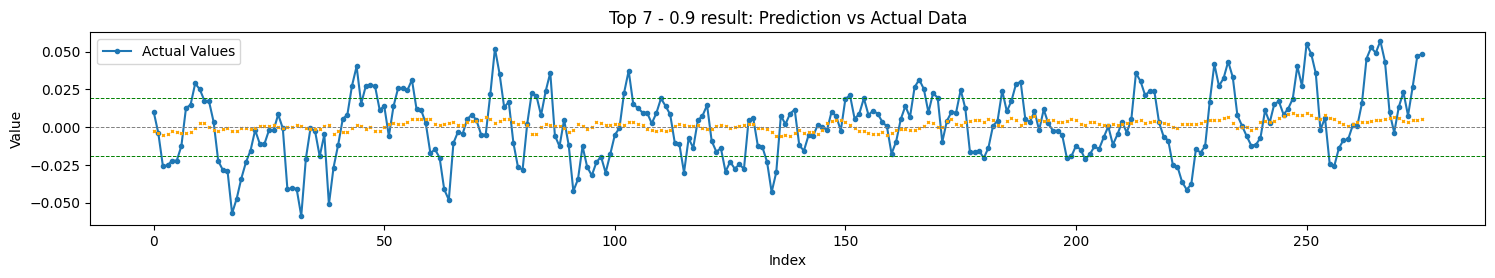

Total TH Pred.: 0


Top 8 - 0.9
RMSE: 0.021928, STD_DEV: 0.022002, STD_PRD: 0.005410, OBJDIFF: 0.004074, RDIFF: -0.000074
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 75, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022877, inv. diff> 0.009171
Trend accuracy       : 52.030
Trend up accuracy    : 64.828
Trend down accuracy  : 37.302


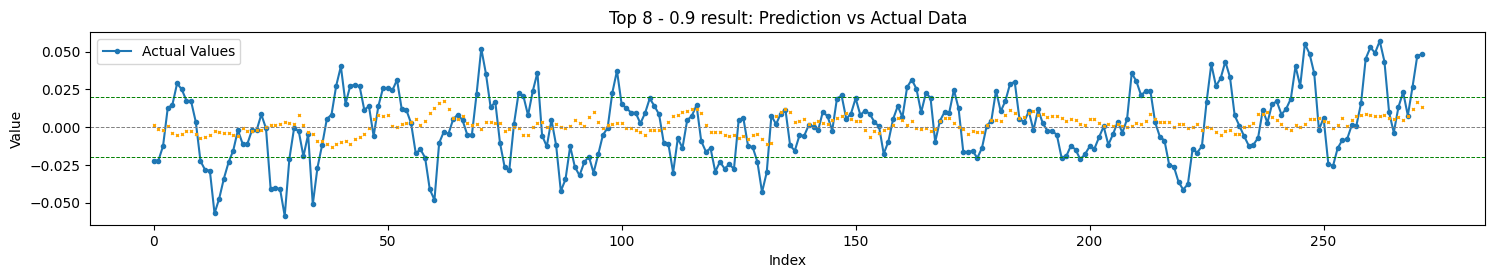

Total TH Pred.: 0


Top 9 - 0.9
RMSE: 0.021642, STD_DEV: 0.022002, STD_PRD: 0.003914, OBJDIFF: 0.004162, RDIFF: -0.000359
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022384, inv. diff> 0.009426
Trend accuracy       : 57.934
Trend up accuracy    : 57.931
Trend down accuracy  : 57.937


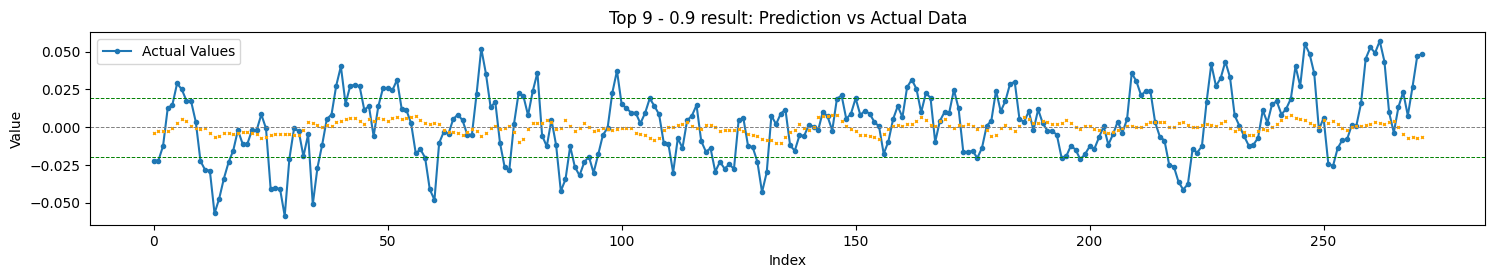

Total TH Pred.: 0


Top 10 - 0.9
RMSE: 0.021897, STD_DEV: 0.021968, STD_PRD: 0.003949, OBJDIFF: 0.004433, RDIFF: -0.000072
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022321, inv. diff> 0.009362
Trend accuracy       : 52.364
Trend up accuracy    : 39.041
Trend down accuracy  : 67.442


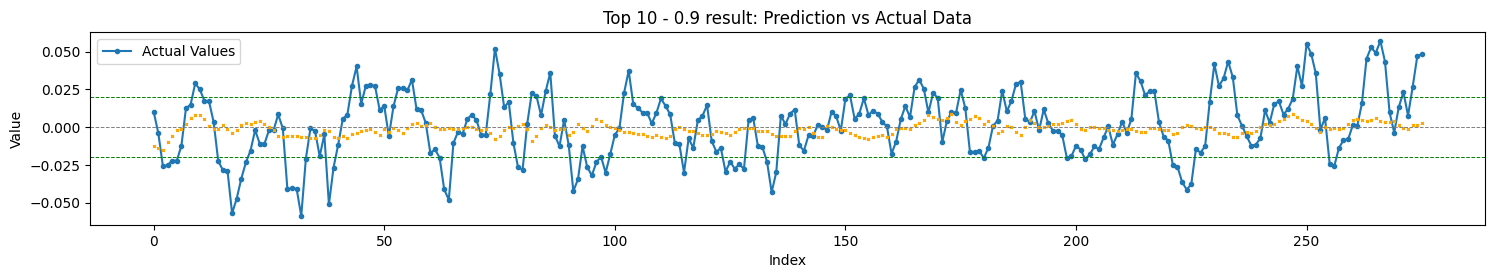

Total TH Pred.: 0


Top 11 - 0.9
RMSE: 0.021910, STD_DEV: 0.021968, STD_PRD: 0.003931, OBJDIFF: 0.004451, RDIFF: -0.000059
batch_size: 64, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022419, inv. diff> 0.009469
Trend accuracy       : 49.455
Trend up accuracy    : 63.014
Trend down accuracy  : 34.109


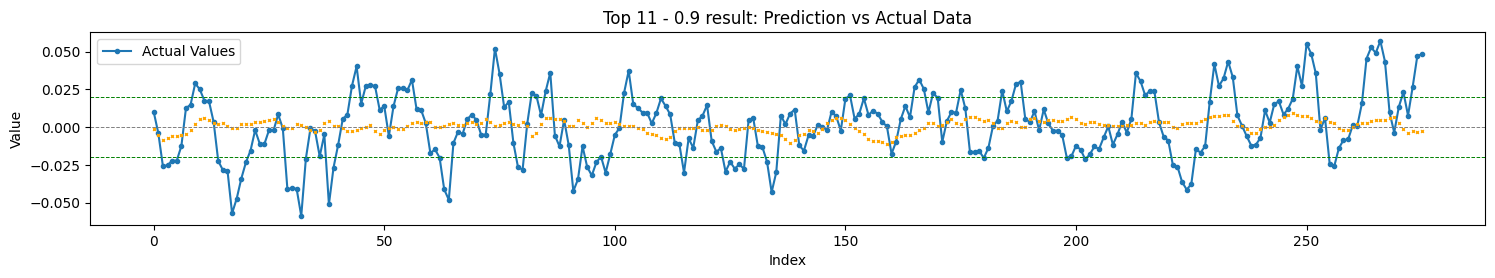

Total TH Pred.: 0


Top 12 - 0.9
RMSE: 0.021988, STD_DEV: 0.022002, STD_PRD: 0.003545, OBJDIFF: 0.004601, RDIFF: -0.000014
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 75, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022379, inv. diff> 0.009605
Trend accuracy       : 47.601
Trend up accuracy    : 57.241
Trend down accuracy  : 36.508


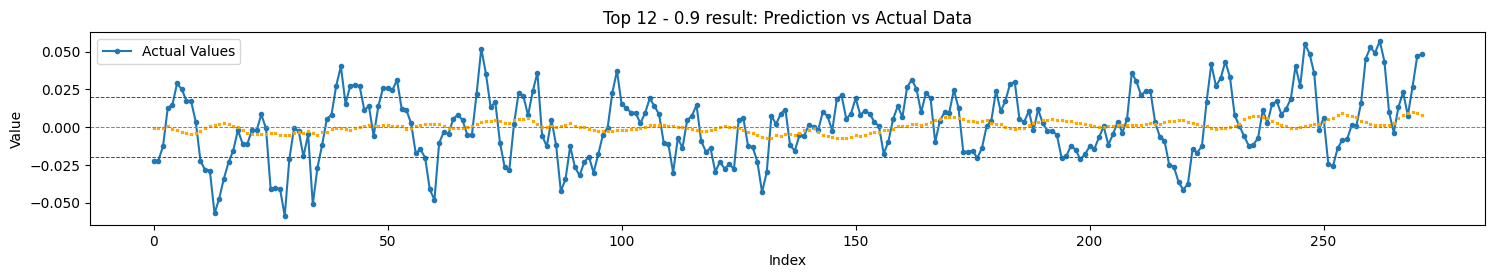

Total TH Pred.: 0


Top 13 - 0.9
RMSE: 0.021995, STD_DEV: 0.022002, STD_PRD: 0.002435, OBJDIFF: 0.004885, RDIFF: -0.000007
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 75, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022324, inv. diff> 0.010106
Trend accuracy       : 51.095
Trend up accuracy    : 76.552
Trend down accuracy  : 22.481


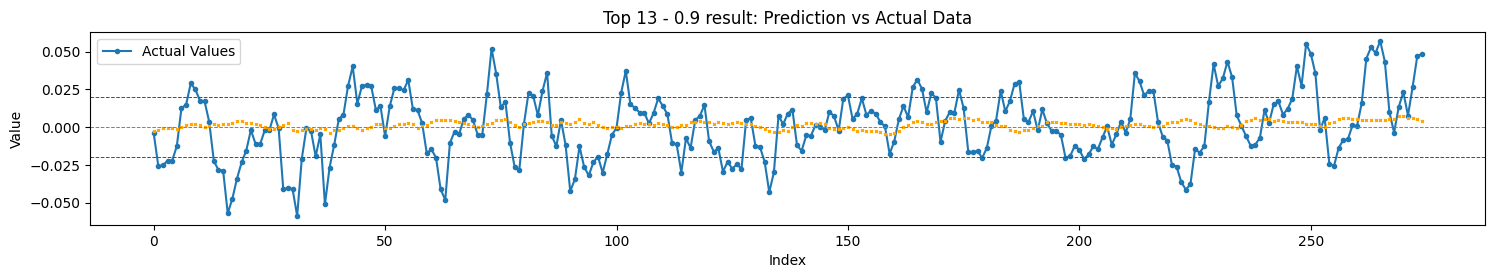

Total TH Pred.: 0


Top 14 - 0.9
RMSE: 0.028833, STD_DEV: 0.022002, STD_PRD: 0.020668, OBJDIFF: 0.007498, RDIFF: 0.006831
batch_size: 64, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 75, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.HeNormal object at 0x7495c47879a0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.030244, inv. diff> 0.008909
Trend accuracy       : 55.720
Trend up accuracy    : 55.862
Trend down accuracy  : 55.556


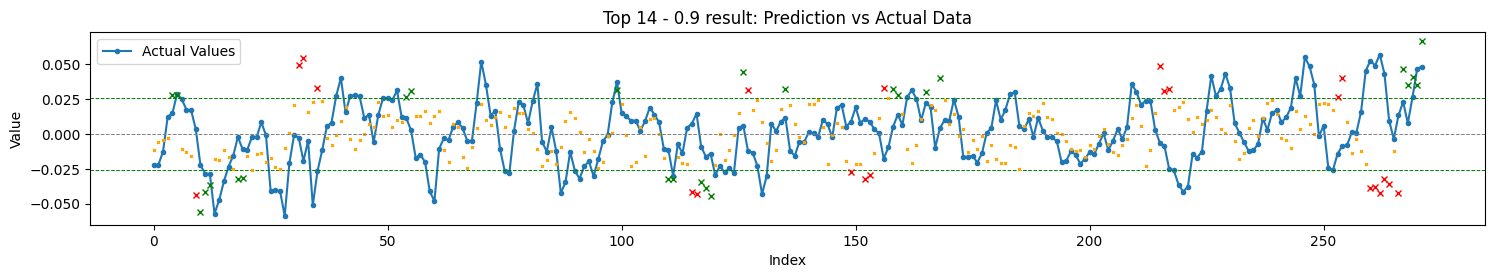

Total TH Pred.: 48
TH Pred. acc. : 54.17


Top 15 - 0.9
RMSE: 0.026621, STD_DEV: 0.021968, STD_PRD: 0.016179, OBJDIFF: 0.007547, RDIFF: 0.004653
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.HeNormal object at 0x7495c47879a0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.027305, inv. diff> 0.008231
Trend accuracy       : 52.727
Trend up accuracy    : 49.315
Trend down accuracy  : 56.589


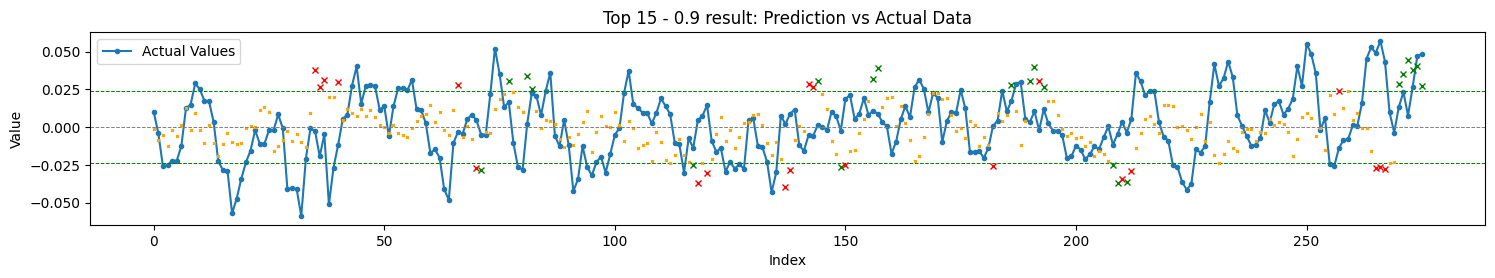

Total TH Pred.: 43
TH Pred. acc. : 51.16


Top 1 - 1.0
RMSE: 0.021396, STD_DEV: 0.021968, STD_PRD: 0.007593, OBJDIFF: 0.003022, RDIFF: -0.000572
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023853, inv. diff> 0.009073
Trend accuracy       : 59.273
Trend up accuracy    : 76.712
Trend down accuracy  : 39.535


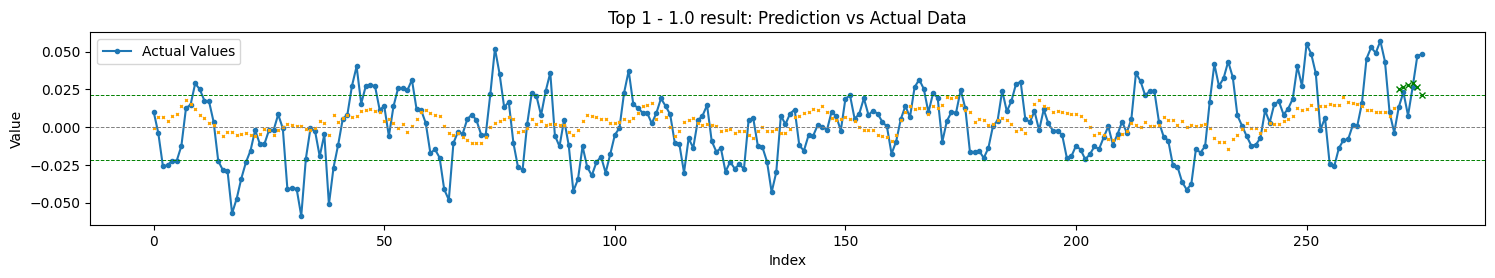

Total TH Pred.: 6
TH Pred. acc. : 100.00


Top 2 - 1.0
RMSE: 0.021314, STD_DEV: 0.022002, STD_PRD: 0.006986, OBJDIFF: 0.003066, RDIFF: -0.000688
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023377, inv. diff> 0.008883
Trend accuracy       : 53.650
Trend up accuracy    : 69.655
Trend down accuracy  : 35.659


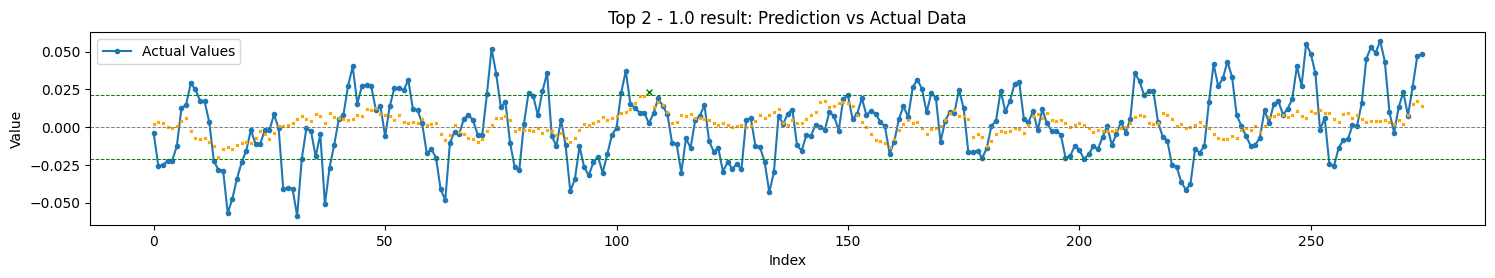

Total TH Pred.: 1
TH Pred. acc. : 100.00


Top 3 - 1.0
RMSE: 0.021549, STD_DEV: 0.022002, STD_PRD: 0.007305, OBJDIFF: 0.003222, RDIFF: -0.000452
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023508, inv. diff> 0.008855
Trend accuracy       : 59.124
Trend up accuracy    : 69.655
Trend down accuracy  : 47.287


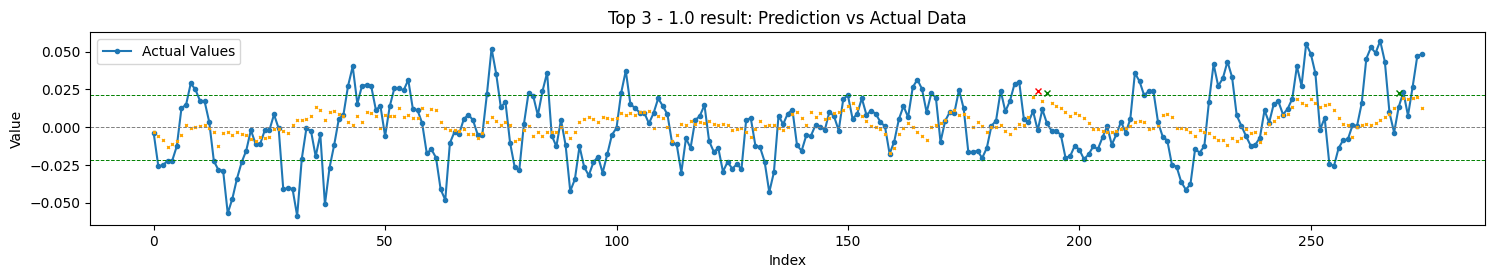

Total TH Pred.: 3
TH Pred. acc. : 66.67


Top 4 - 1.0
RMSE: 0.021346, STD_DEV: 0.022002, STD_PRD: 0.005851, OBJDIFF: 0.003382, RDIFF: -0.000656
batch_size: 64, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023008, inv. diff> 0.009081
Trend accuracy       : 57.934
Trend up accuracy    : 73.103
Trend down accuracy  : 40.476


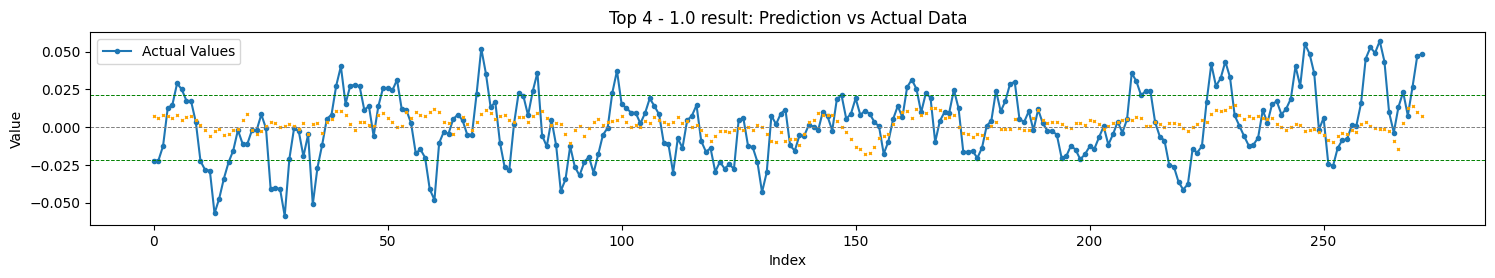

Total TH Pred.: 0


Top 5 - 1.0
RMSE: 0.021730, STD_DEV: 0.021968, STD_PRD: 0.007309, OBJDIFF: 0.003427, RDIFF: -0.000238
batch_size: 64, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023367, inv. diff> 0.008729
Trend accuracy       : 58.909
Trend up accuracy    : 70.548
Trend down accuracy  : 45.736


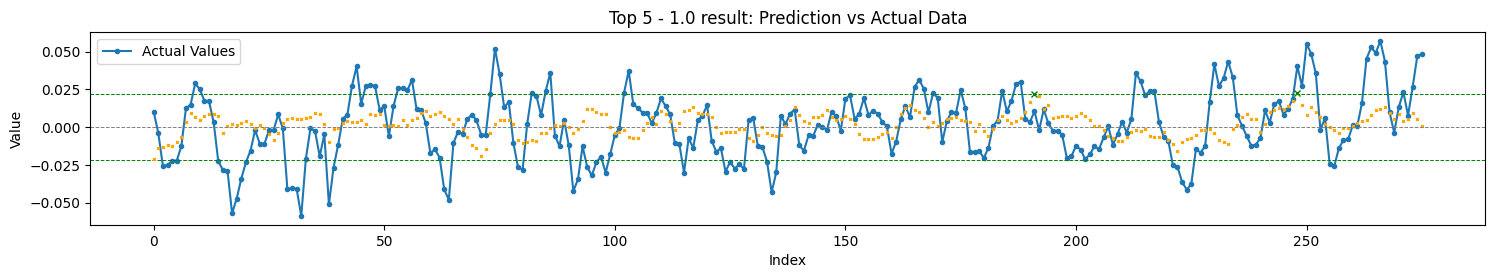

Total TH Pred.: 2
TH Pred. acc. : 100.00


Top 6 - 1.0
RMSE: 0.021968, STD_DEV: 0.021968, STD_PRD: 0.006441, OBJDIFF: 0.003881, RDIFF: -0.000001
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.023266, inv. diff> 0.009062
Trend accuracy       : 56.364
Trend up accuracy    : 71.918
Trend down accuracy  : 38.760


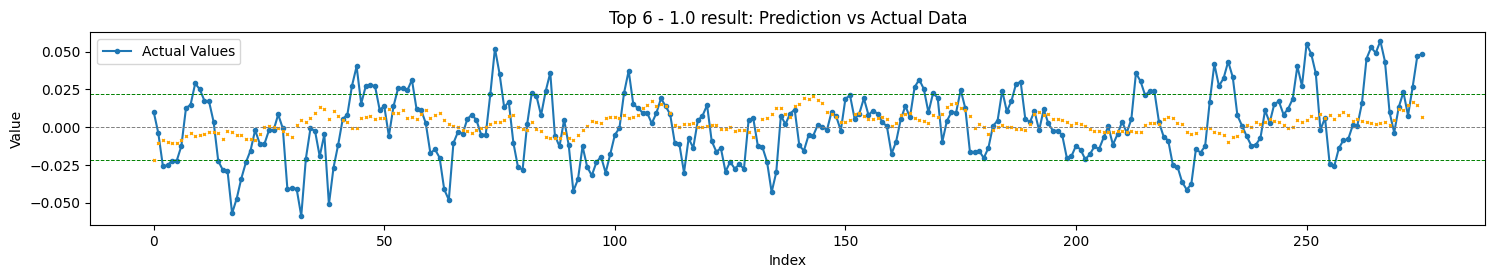

Total TH Pred.: 0


Top 7 - 1.0
RMSE: 0.021253, STD_DEV: 0.021968, STD_PRD: 0.003182, OBJDIFF: 0.003981, RDIFF: -0.000715
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022365, inv. diff> 0.009790
Trend accuracy       : 53.455
Trend up accuracy    : 70.548
Trend down accuracy  : 34.109


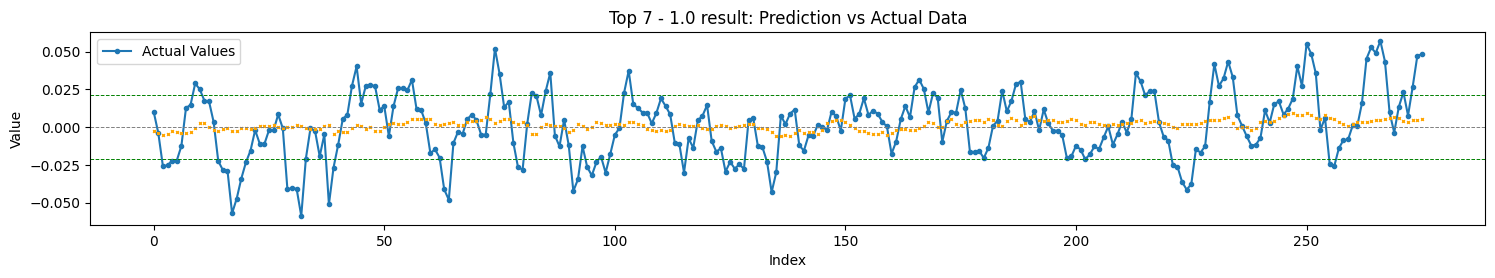

Total TH Pred.: 0


Top 8 - 1.0
RMSE: 0.021928, STD_DEV: 0.022002, STD_PRD: 0.005410, OBJDIFF: 0.004074, RDIFF: -0.000074
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 75, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.GlorotUniform object at 0x7495cd0f7b50>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022877, inv. diff> 0.009171
Trend accuracy       : 52.030
Trend up accuracy    : 64.828
Trend down accuracy  : 37.302


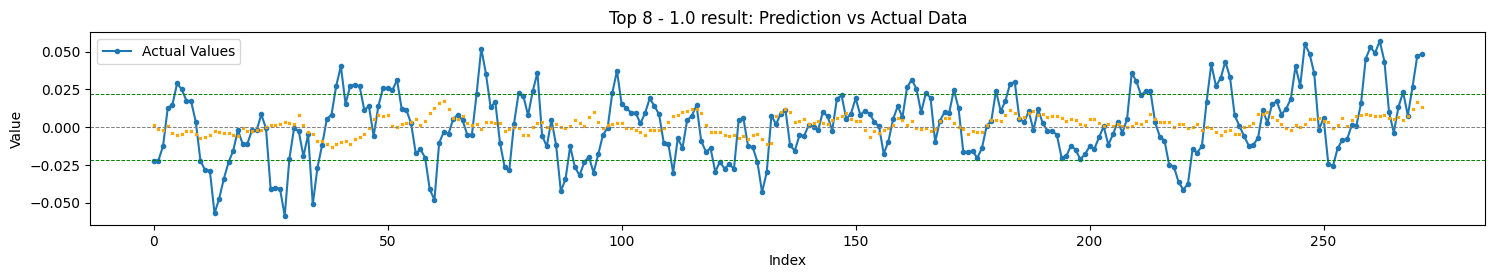

Total TH Pred.: 0


Top 9 - 1.0
RMSE: 0.021642, STD_DEV: 0.022002, STD_PRD: 0.003914, OBJDIFF: 0.004162, RDIFF: -0.000359
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022384, inv. diff> 0.009426
Trend accuracy       : 57.934
Trend up accuracy    : 57.931
Trend down accuracy  : 57.937


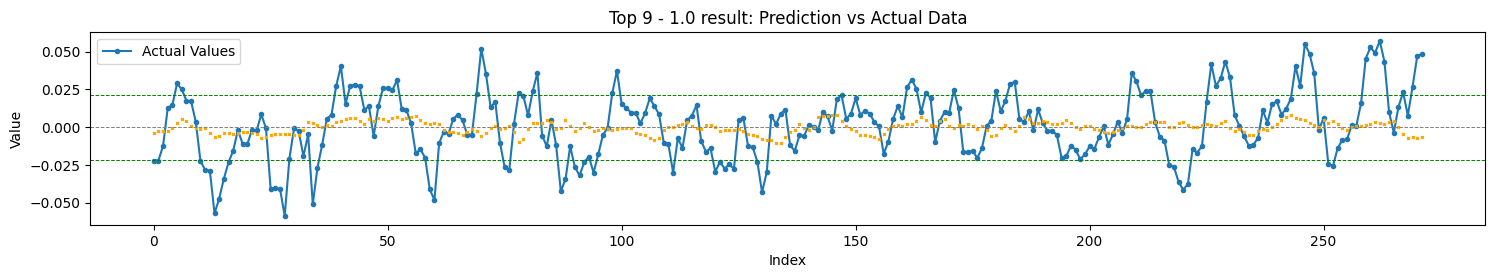

Total TH Pred.: 0


Top 10 - 1.0
RMSE: 0.021897, STD_DEV: 0.021968, STD_PRD: 0.003949, OBJDIFF: 0.004433, RDIFF: -0.000072
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022321, inv. diff> 0.009362
Trend accuracy       : 52.364
Trend up accuracy    : 39.041
Trend down accuracy  : 67.442


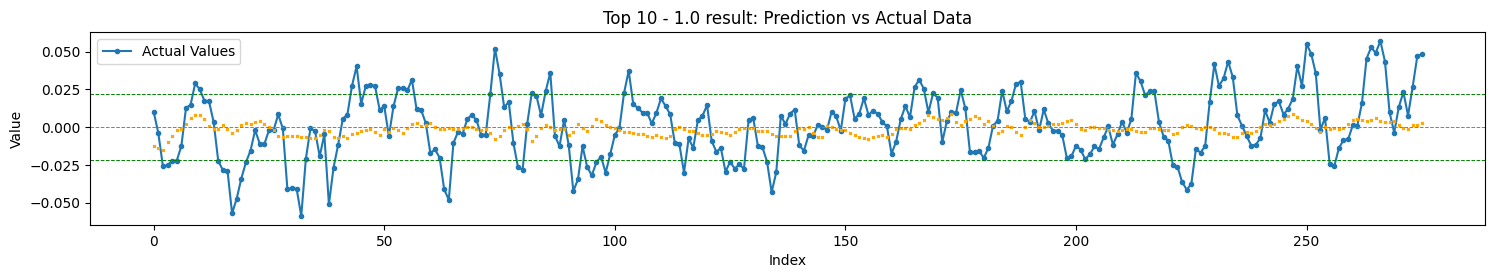

Total TH Pred.: 0


Top 11 - 1.0
RMSE: 0.021910, STD_DEV: 0.021968, STD_PRD: 0.003931, OBJDIFF: 0.004451, RDIFF: -0.000059
batch_size: 64, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022419, inv. diff> 0.009469
Trend accuracy       : 49.455
Trend up accuracy    : 63.014
Trend down accuracy  : 34.109


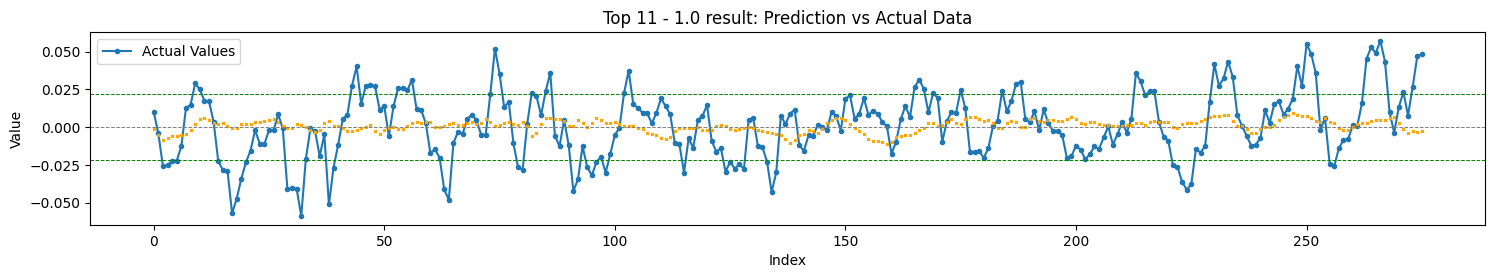

Total TH Pred.: 0


Top 12 - 1.0
RMSE: 0.021988, STD_DEV: 0.022002, STD_PRD: 0.003545, OBJDIFF: 0.004601, RDIFF: -0.000014
batch_size: 128, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 75, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022379, inv. diff> 0.009605
Trend accuracy       : 47.601
Trend up accuracy    : 57.241
Trend down accuracy  : 36.508


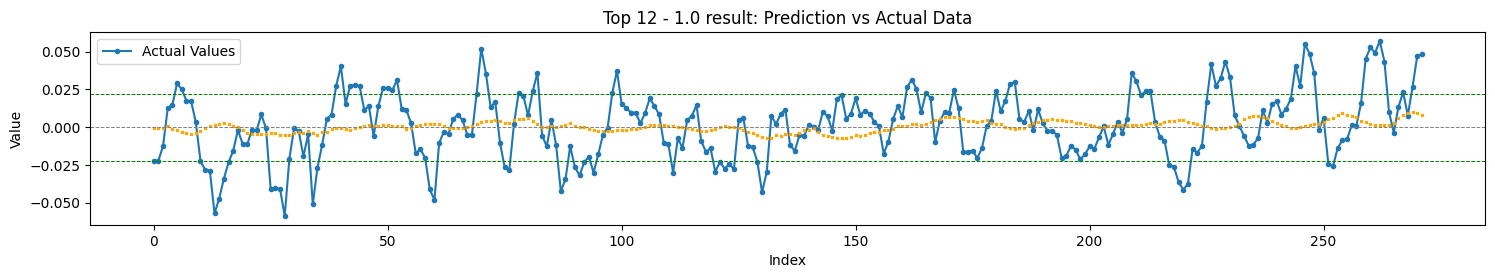

Total TH Pred.: 0


Top 13 - 1.0
RMSE: 0.021995, STD_DEV: 0.022002, STD_PRD: 0.002435, OBJDIFF: 0.004885, RDIFF: -0.000007
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 75, 'lstm_units2': 75, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.Orthogonal object at 0x7494ee759de0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.022324, inv. diff> 0.010106
Trend accuracy       : 51.095
Trend up accuracy    : 76.552
Trend down accuracy  : 22.481


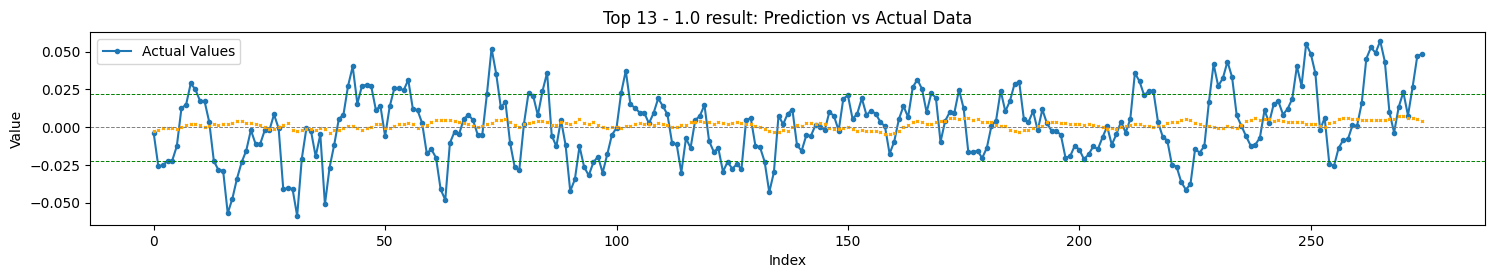

Total TH Pred.: 0


Top 14 - 1.0
RMSE: 0.028833, STD_DEV: 0.022002, STD_PRD: 0.020668, OBJDIFF: 0.007498, RDIFF: 0.006831
batch_size: 64, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 75, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.HeNormal object at 0x7495c47879a0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.030244, inv. diff> 0.008909
Trend accuracy       : 55.720
Trend up accuracy    : 55.862
Trend down accuracy  : 55.556


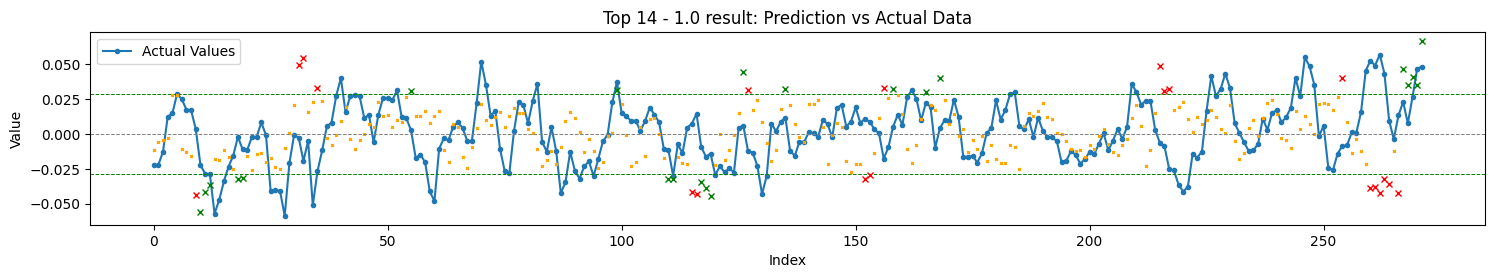

Total TH Pred.: 42
TH Pred. acc. : 52.38


Top 15 - 1.0
RMSE: 0.026621, STD_DEV: 0.021968, STD_PRD: 0.016179, OBJDIFF: 0.007547, RDIFF: 0.004653
batch_size: 256, epochs: 300
Model params:  {'lstm_units1': 25, 'lstm_units2': 25, 'activation': 'relu', 'dropout': 0.15, 'num_layers': 2, 'initializer': <keras.src.initializers.initializers.HeNormal object at 0x7495c47879a0>}
Feature list:  ['LMCADS03', 'LMCADY', 'SPX', 'MXWD', 'XAG', 'XAU', 'ACU_5D', 'ACU_4D', 'ACU_3D', 'ACU_2D']
Inv. rmse> 0.027305, inv. diff> 0.008231
Trend accuracy       : 52.727
Trend up accuracy    : 49.315
Trend down accuracy  : 56.589


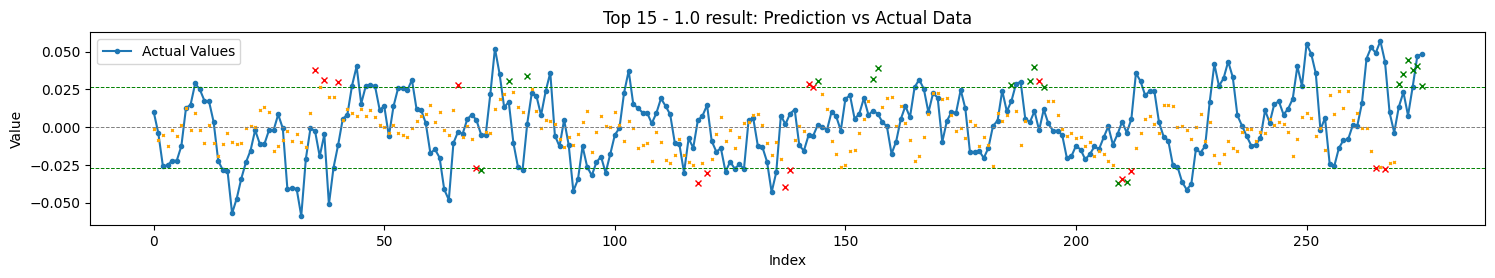

Total TH Pred.: 34
TH Pred. acc. : 52.94




In [ ]:
for mult in [.5,.6,.7,.8,.9,1.0]:
    for i,result in enumerate(top_results_sort,1):

        # if result['rmse']-result['std_dev'] >= 0:
        #     continue

        print(f"Top {i} - {mult}")

        # if (result['rmse']<result['std_dev']):
        #     result['diff'] = result['rmse']-result['std_dev'] + abs(np.std(result['predictions']) - result['std_dev'])/4.0
        # else:
        #     result['diff'] = (result['rmse']- result['std_dev']) + abs(np.std(result['predictions']) - result['std_dev'])/2.0

        print("RMSE: {:.6f}, STD_DEV: {:.6f}, STD_PRD: {:.6f}, OBJDIFF: {:.6f}, RDIFF: {:.6f}".format(result['rmse'], result['std_dev'], np.std(result['predictions']), result['diff'],result['rmse']-result['std_dev']))
        # print("n_steps: {}, batch_size: {}, epochs: {}".format(result['n_steps'], result['batch_size'], result['epochs']))
        print("batch_size: {}, epochs: {}".format(result['batch_size'], result['epochs']))
        print("Model params: ", result['md_prm'])
        print("Feature list: ", result['feature_list'])

        # var_tot     = set(variable_options)
        # fea_list    = set(result['feature_list'])
        # print("Discarded var: {}".format(var_tot - fea_list))

        result['inv_rmse'] = inv_rmse = rmse(result['true_values'], result['predictions']*-1)
        inv_diff = (inv_rmse - result['std_dev']) + abs(np.std(result['predictions']) - result['std_dev'])/2.0
        print("Inv. rmse> {:.6f}, inv. diff> {:.6f}".format(inv_rmse, inv_diff))

        # calculate trend prediction percentage

        trend_up_true   = 0
        trend_down_true = 0
        trend_up_pred   = 0
        trend_down_pred = 0

        for j in range(len(result['true_values'])-1):
            if result['true_values'][j] > 0.0:
                trend_up_pred += 1
                if result['predictions'][j] > 0.0:
                    trend_up_true += 1
            if result['true_values'][j] < 0.0:
                trend_down_pred += 1
                if result['predictions'][j] < 0.0:
                    trend_down_true += 1

        trend_true      = trend_up_true + trend_down_true
        trend_pred      = trend_up_pred + trend_down_pred
        trend_accuracy  = trend_true/trend_pred
        print("Trend accuracy       : {:.3f}".format(trend_accuracy*100))
        print("Trend up accuracy    : {:.3f}".format(trend_up_true*100/trend_up_pred))
        print("Trend down accuracy  : {:.3f}".format(trend_down_true*100/trend_down_pred))


        tot_pred, prof, loss = plot_predictions(result['true_values'], result['predictions'],-1, title=f"Top {i} - {mult} result: Prediction vs Actual Data",rmse=result['rmse']*mult)
        print("Total TH Pred.: {}".format(tot_pred))
        if tot_pred != 0:
            print("TH Pred. acc. : {:.2f}".format(prof*100.0/tot_pred))
        print('\n')


In [ ]:
# export the best result predictions and true values to a csv file
best_result = top_results[6]
best_result_df = pd.DataFrame({'True Values': best_result['true_values'], 'Predictions': best_result['predictions'].flatten()})
best_result_df.to_csv('../output/lstm_best_result.csv', index=False)